dict_keys(['return'])
No outbound leg found.


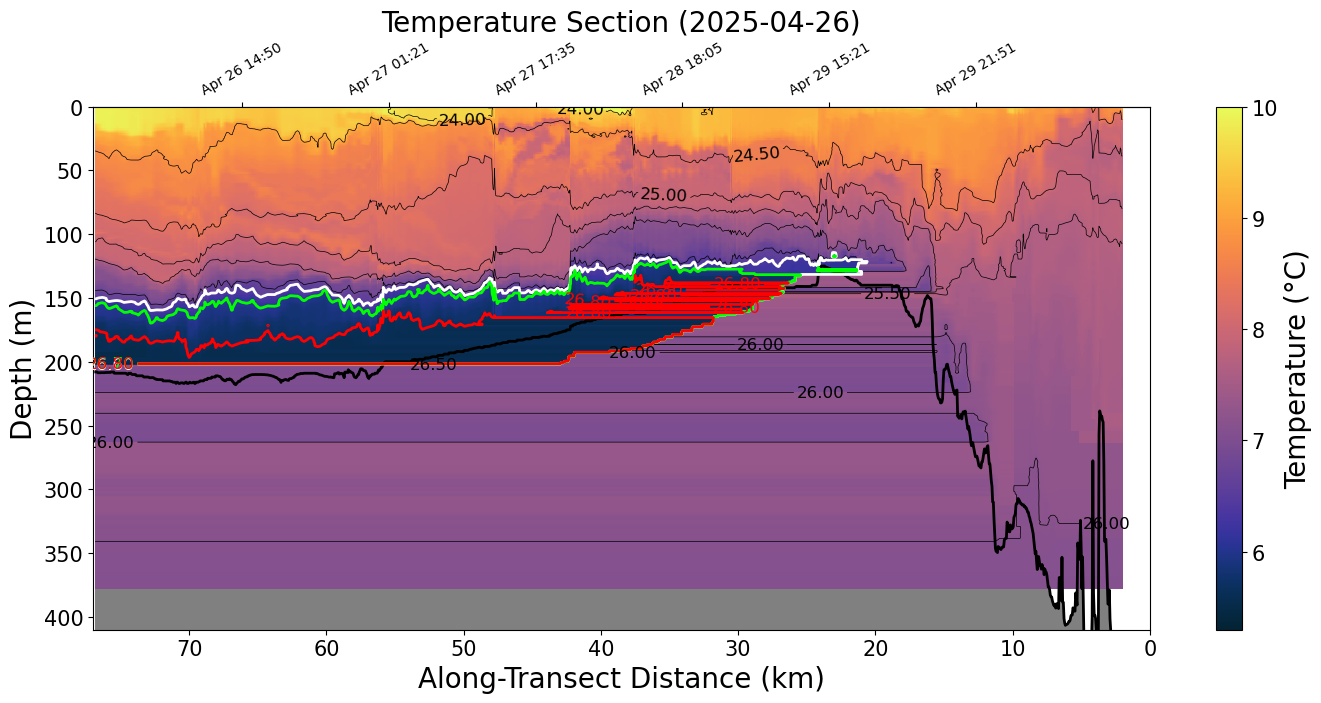

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import waypoint_distance as wd
import pandas as pd

def plot_section(ds, xlim = 77):
    """
    Plot temperature section for a given file

    Parameters:
    - ds: xarray.Dataset, a .nc file for each transect
    - temp_bounds: tuple, (min, max) temperature values for colormap.
    """

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})
    
    topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
    topo = xr.open_dataset(topo_file)
    ds = ds
    temp_bounds = (5.3, 10)
    # Extract coordinates and data
    along = ds['along'].values
    depth = ds['depth'].values
    temperature = ds['temperature'].values
    pdens = ds['potential_density'].values - 1000  # Sigma-theta

    # Interpolate bathymetry over full along track
    full_lon = ds['longitude'].values
    full_lat = ds['latitude'].values

    interp_bathy = topo['Band1'].interp(
        lon=xr.DataArray(full_lon, dims='along'),
        lat=xr.DataArray(full_lat, dims='along'),
        method='nearest')
    bottom_depths = -interp_bathy.values  # 1D array for full along

    # Plot temperature section
    fig, ax = plt.subplots(figsize=( 1.5 * 1.5 * 6.4, 1.5 * 4.8))
    # Create meshgrid of depth and along
    depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')

    # Expand bottom_depths to match depth grid shape
    bathymetry_floor = np.tile(bottom_depths, (len(depth), 1))

    # Create mask where depth > bottom
    mask = depth_grid > bathymetry_floor

    # Step 1: Get deepest valid depth at each along point
    deepest_valid_depth = np.full_like(along, np.nan)
    for i in range(len(along)):
        col = temp[:, i]
        if np.any(~np.isnan(col)):
            deepest_valid_depth[i] = depth[~np.isnan(col)].max()

    # Step 2: Smooth using rolling average over 10 points (or 500 m)
    window = 10  # adjust as needed
    deepest_valid_depth_smoothed = pd.Series(deepest_valid_depth).rolling(window, min_periods=1, center=True).mean().values

    # Step 3: Interpolate smoothed profile to fine along grid
    deepest_interp = np.interp(along_grid_m, along, deepest_valid_depth_smoothed)

    # Step 4: Build final masking limit
    deepest_floor = np.tile(deepest_interp, (depth_grid.size, 1))
    valid_region = (D <= bathy_floor - 19) & (D <= deepest_floor)

    # Plot grey background
    ax.contourf(along / 1000, depth, mask,
                levels=[0.5, 1.5], colors='grey', zorder=1)
    cf = ax.pcolormesh(along / 1000, depth, temperature, shading='auto',
                        cmap=cm.cm.thermal, vmin=temp_bounds[0], vmax=temp_bounds[1])

    # Bathymetry
    ax.plot(along / 1000, bottom_depths, color='black', linewidth=2)

    # Isopycnal contours
    for levels, color, lw in [
        (np.linspace(24, 27, 7), 'black', 0.5),
        ([26.6], 'white', 2),
        ([26.7], 'lime', 2),
        ([26.8], 'red', 2),
        ([26.9], 'blue', 2)]:
        cf_iso = ax.contour(along / 1000, depth, pdens, levels=levels,
                            colors=color, linewidths=lw, linestyles='-')
        if lw != 0.3:
            ax.clabel(cf_iso, fmt='%1.2f')

    time_top = ds['time'].values  # shape (along,)
    along_km = along / 1000

    # Number of ticks you want
    nticks = 8
    idx_ticks = np.linspace(0, len(along_km) - 1, nticks, dtype=int)

    tick_locs = along_km[idx_ticks]
    tick_times = time_top[idx_ticks]

    # Remove NaT values
    valid_mask = ~pd.isna(tick_times)
    tick_locs = tick_locs[valid_mask]
    tick_times = tick_times[valid_mask]

    # Format with hour and date
    tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

    # Add secondary x-axis with formatted time ticks
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(tick_locs)
    ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

    # Labels and formatting
    ax.set_xlabel('Along-Transect Distance (km)')
    ax.set_ylabel('Depth (m)')
    ax.invert_yaxis()
    ax.set_ylim(410, 0)
    ax.set_xlim(xlim,0)
    earliest_time = pd.to_datetime(min(tick_times))
    tstr = earliest_time.strftime('%Y-%m-%d')
    ax.set_title(f'Temperature Section ({tstr})')
    plt.colorbar(cf, ax=ax, label='Temperature (°C)')
    plt.tight_layout()

def interpolate(ds, step=50, extrapolate=True):
    import numpy as np
    import xarray as xr

    # Remove duplicate along values
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)

    # Build regular along grid
    min_along = np.floor(ds['along'].min().item() / step) * step
    max_along = np.ceil(ds['along'].max().item() / step) * step
    along_grid = np.arange(min_along, max_along + 1, step)

    # Swap time with along for interpolation
    ds = ds.swap_dims({'time': 'along'})
    ds_interp = ds.interp(along=along_grid)

    # Interpolate time manually
    interp_time = np.interp(
        along_grid,
        ds['along'].values,
        ds['time'].values.astype('datetime64[ns]').astype('float64'),
        left=np.nan,
        right=np.nan
    )
    ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

    # Fill NaNs along 'along', one depth at a time using nearest
    for var in ds_interp.data_vars:
        da = ds_interp[var]
        if 'along' not in da.dims or 'depth' not in da.dims:
            continue  # skip 1D or unrelated variables

        filled_rows = []
        depths = ds_interp['depth'].values
        along_vals = ds_interp['along'].values

        for i in range(len(depths)):
            row = da.isel(depth=i)

            filled = row.interpolate_na(
                dim='along',
                method='nearest',
                fill_value='extrapolate' if extrapolate else None
            )
            filled_rows.append(filled.values)

        # Rebuild filled variable
        new_da = xr.DataArray(
            data=np.array(filled_rows),
            dims=('depth', 'along'),
            coords={'depth': depths, 'along': along_vals}
        )
        ds_interp[var] = new_da

    return ds_interp

file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
# file_pathway = '~/Desktop/dfo-hal1002-20250506_grid.nc'
ds = xr.open_dataset(file_pathway)

waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
central_lat = 51.715

alongx, acrossx, _ = wd.get_simple_distance(
    shiplon=ds['longitude'].values,
    shiplat=ds['latitude'].values,
    wplon=waypoint_lon,
    wplat=waypoint_lat,
    central_lat=central_lat)

ds = ds.assign(along=('time', alongx), across=('time', acrossx))

peak_idx = int(np.argmax(ds['along'].values))
ds_out = ds.isel(time=slice(0, peak_idx + 1))
ds_return = ds.isel(time=slice(peak_idx + 1, None))

results = {}

for leg, name in [(ds_out, "out"), (ds_return, "return")]:
    try:
        if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
            continue

        prev_len = -1
        while prev_len != len(leg['time']):
            if len(leg['along']) < 3:
                raise ValueError("Too short for gradient")
            prev_len = len(leg['time'])
            grad = np.gradient(leg['along'].values)
            keep_mask = grad > 0 if name == "out" else grad < 0
            leg = leg.sel(time=keep_mask)

        if np.count_nonzero(~np.isnan(leg['along'])) < 100:
            continue

        # ✅ Interpolate before assigning to results
        leg_interp = interpolate(leg, step=50)
        results[name] = leg_interp

    except Exception as e:
        print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
        continue

# Check what made it into results
print(results.keys())  # Should show 'out', 'return' if both passed

# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

# Example: plot outbound leg
if ds_out_cleaned is not None:
    plot_section(ds_out_cleaned)
    plt.show()
else:
    print("No outbound leg found.")

# Example: plot return leg
if ds_return_cleaned is not None:
    plot_section(ds_return_cleaned)
    plt.show()
else:
    print("No return leg found.")


# Soooo the above plot is the interp and extrap logic that we want to use, it just needs some masking so we're not misrepresenting our data.

### 11:40 pm Friday correct interpolation method minus that we still need to mask for below where data was taken outside of the basin ###

No outbound leg found.


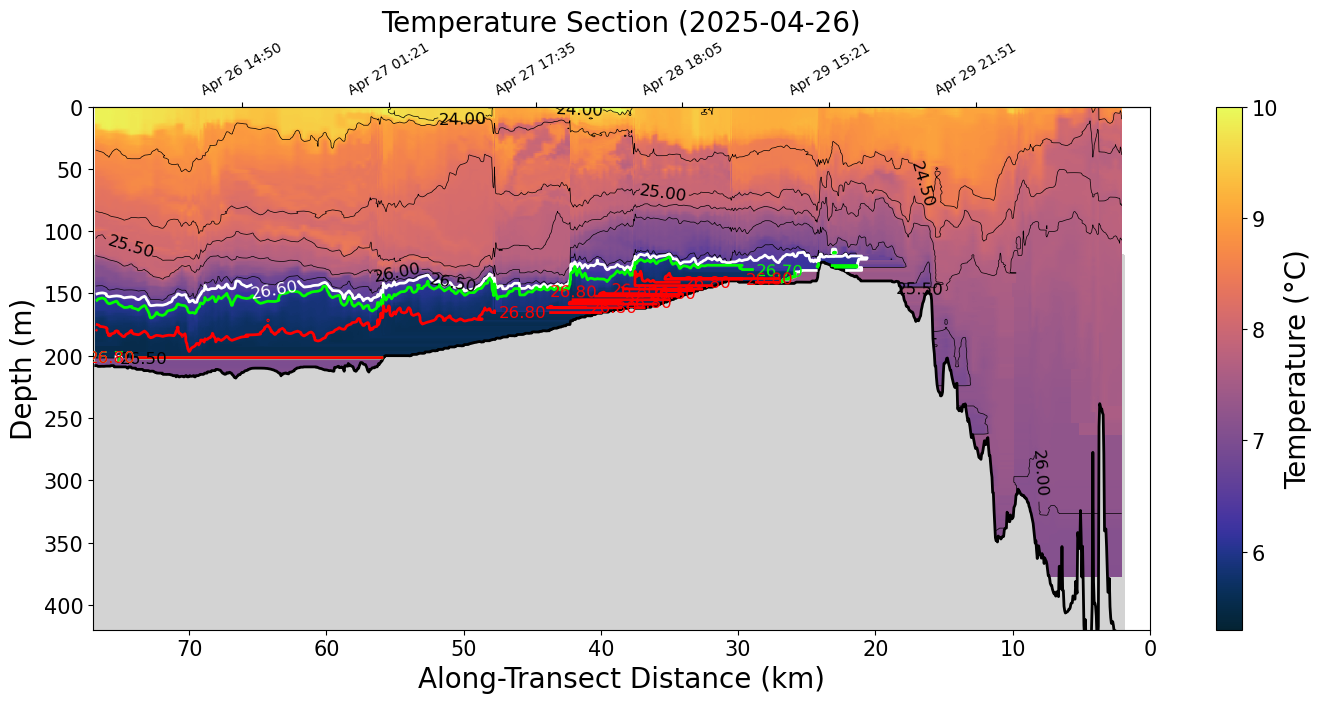

In [72]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import waypoint_distance as wd
import pandas as pd

def plot_section(ds, xlim=77):
    """
    Plot temperature section for a given file

    Parameters:
    - ds: xarray.Dataset, a .nc file for each transect
    - xlim: float, maximum distance (km) along transect to plot
    """

    # ─── Styling ─────────────────────────────────────────
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    # ─── Load Bathymetry ────────────────────────────────
    topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
    topo = xr.open_dataset(topo_file)

    # ─── Extract variables ──────────────────────────────
    along = ds['along'].values
    depth = ds['depth'].values
    temperature = ds['temperature'].values
    pdens = ds['potential_density'].values - 1000  # sigma-theta
    lon = ds['longitude'].values
    lat = ds['latitude'].values
    time_top = ds['time'].values  # shape (along,)

    # ─── Interpolate Bathymetry ─────────────────────────
    interp_bathy = topo['Band1'].interp(
        lon=xr.DataArray(lon, dims='along'),
        lat=xr.DataArray(lat, dims='along'),
        method='nearest')
    ocean_floor = -interp_bathy.values
    below_ocean_floor= np.linspace(120, 420, 301)
    depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')
    below_ocean_floor_grid, along_grid = np.meshgrid(below_ocean_floor, along, indexing='ij')
    valid_region_for_temp = (depth_grid <= ocean_floor)
    valid_region_for_bathy = (below_ocean_floor_grid <= ocean_floor)
    
    # ─── Plot ───────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))

    # Mask temperature below bathymetry
    temperature_masked = np.where(valid_region_for_temp, temperature, np.nan)
    pdens_masked = np.where(valid_region_for_temp, pdens, np.nan)

    # Plot light grey base first (below everything)
    ax.pcolormesh(along_grid / 1000, below_ocean_floor_grid, 
                np.where(valid_region_for_bathy, np.nan, 1),
                color='lightgrey', shading='auto', vmin=0, vmax=1, zorder=1)
    
    # Plot masked temperature field
    cf = ax.pcolormesh(along / 1000, depth, temperature_masked, 
                    shading='auto', cmap=cm.cm.thermal, 
                    vmin=5.3, vmax=10, zorder=2)

    # Plot bathymetry
    ax.plot(along / 1000, ocean_floor, color='black', linewidth=2)

    # Isopycnals
    for levels, color, lw in [
        (np.linspace(24, 27, 7), 'black', 0.5),
        ([26.6], 'white', 2),
        ([26.7], 'lime', 2),
        ([26.8], 'red', 2),
        ([26.9], 'blue', 2)]:
        cf_iso = ax.contour(along / 1000, depth, pdens_masked, levels=levels,
                            colors=color, linewidths=lw, linestyles='-')
        if lw != 0.3:
            ax.clabel(cf_iso, fmt='%1.2f')

    # ─── Top Axis with Time Labels ──────────────────────
    along_km = along / 1000
    nticks = 8
    idx_ticks = np.linspace(0, len(along_km) - 1, nticks, dtype=int)
    tick_locs = along_km[idx_ticks]
    tick_times = time_top[idx_ticks]

    # Remove NaT
    valid_mask = ~pd.isna(tick_times)
    tick_locs = tick_locs[valid_mask]
    tick_times = tick_times[valid_mask]
    tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(tick_locs)
    ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

    # ─── Labels and Limits ──────────────────────────────
    ax.set_xlabel('Along-Transect Distance (km)')
    ax.set_ylabel('Depth (m)')
    ax.invert_yaxis()
    ax.set_ylim(420, 0)
    ax.set_xlim(xlim, 0)

    earliest_time = pd.to_datetime(min(tick_times))
    tstr = earliest_time.strftime('%Y-%m-%d')
    ax.set_title(f'Temperature Section ({tstr})')

    plt.colorbar(cf, ax=ax, label='Temperature (°C)')
    plt.tight_layout()

def interpolate(ds, step=50, extrapolate=True):
    import numpy as np
    import xarray as xr

    # Remove duplicate along values
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)

    # Build regular along grid
    min_along = np.floor(ds['along'].min().item() / step) * step
    max_along = np.ceil(ds['along'].max().item() / step) * step
    along_grid = np.arange(min_along, max_along + 1, step)

    # Swap time with along for interpolation
    ds = ds.swap_dims({'time': 'along'})
    ds_interp = ds.interp(along=along_grid)

    # Interpolate time manually
    interp_time = np.interp(
        along_grid,
        ds['along'].values,
        ds['time'].values.astype('datetime64[ns]').astype('float64'),
        left=np.nan,
        right=np.nan
    )
    ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

    # Get along mask for 0–20 km
    mask_along = (ds_interp['along'] >= 0) & (ds_interp['along'] <= 20000)

    # Subset temp data in that along range
    temp_sub = ds_interp['temperature'].where(mask_along, drop=True)

    # Find the deepest depth where there's at least one valid (non-NaN) temperature
    valid_depths = ds_interp['depth'][~np.all(np.isnan(temp_sub), axis=1)]
    max_valid_depth = valid_depths.max().item()

    # Now limit dataset to just that depth range
    ds_interp = ds_interp.sel(depth=ds_interp['depth'] <= max_valid_depth)

    # Fill NaNs along 'along', one depth at a time using nearest
    for var in ds_interp.data_vars:
        da = ds_interp[var]
        if 'along' not in da.dims or 'depth' not in da.dims:
            continue  # skip 1D or unrelated variables

        filled_rows = []
        depths = ds_interp['depth'].values
        along_vals = ds_interp['along'].values

        for i in range(len(depths)):
            row = da.isel(depth=i)

            filled = row.interpolate_na(
                dim='along',
                method='nearest',
                fill_value='extrapolate')
            filled_rows.append(filled.values)

        # Rebuild filled variable
        new_da = xr.DataArray(
            data=np.array(filled_rows),
            dims=('depth', 'along'),
            coords={'depth': depths, 'along': along_vals})
        ds_interp[var] = new_da

    return ds_interp

if True:
    file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
    # file_pathway = '~/CalvertLine_reprocessed/dfo-eva035-20230811_grid_delayed.nc'
    # file_pathway = '~/CalvertLine_reprocessed/dfo-eva035-20231019_grid_delayed.nc'
    # file_pathway = '~/CalvertLine_reprocessed/dfo-marvin1003-20221018_grid_delayed.nc'
    # file_pathway = '~/Desktop/dfo-hal1002-20250506_grid.nc'
    ds = xr.open_dataset(file_pathway)

    waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
    waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
    central_lat = 51.715

    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat)

    ds = ds.assign(along=('time', alongx), across=('time', acrossx))

    peak_idx = int(np.argmax(ds['along'].values))
    ds_out = ds.isel(time=slice(0, peak_idx + 1))
    ds_return = ds.isel(time=slice(peak_idx + 1, None))

    results = {}

    for leg, name in [(ds_out, "out"), (ds_return, "return")]:
        try:
            if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
                continue

            prev_len = -1
            while prev_len != len(leg['time']):
                if len(leg['along']) < 3:
                    raise ValueError("Too short for gradient")
                prev_len = len(leg['time'])
                grad = np.gradient(leg['along'].values)
                keep_mask = grad > 0 if name == "out" else grad < 0
                leg = leg.sel(time=keep_mask)

            if np.count_nonzero(~np.isnan(leg['along'])) < 100:
                continue

            # ✅ Interpolate before assigning to results
            leg_interp = interpolate(leg, step=50)
            results[name] = leg_interp

        except Exception as e:
            print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
            continue

# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

# Example: plot outbound leg
if ds_out_cleaned is not None:
    plot_section(ds_out_cleaned)
    plt.show()
else:
    print("No outbound leg found.")

# Example: plot return leg
if ds_return_cleaned is not None:
    plot_section(ds_return_cleaned)
    plt.show()
else:
    print("No return leg found.")

# THIS ONE WORKS #

No outbound leg found.
(376, 1483) (376, 1483) (376, 1483)


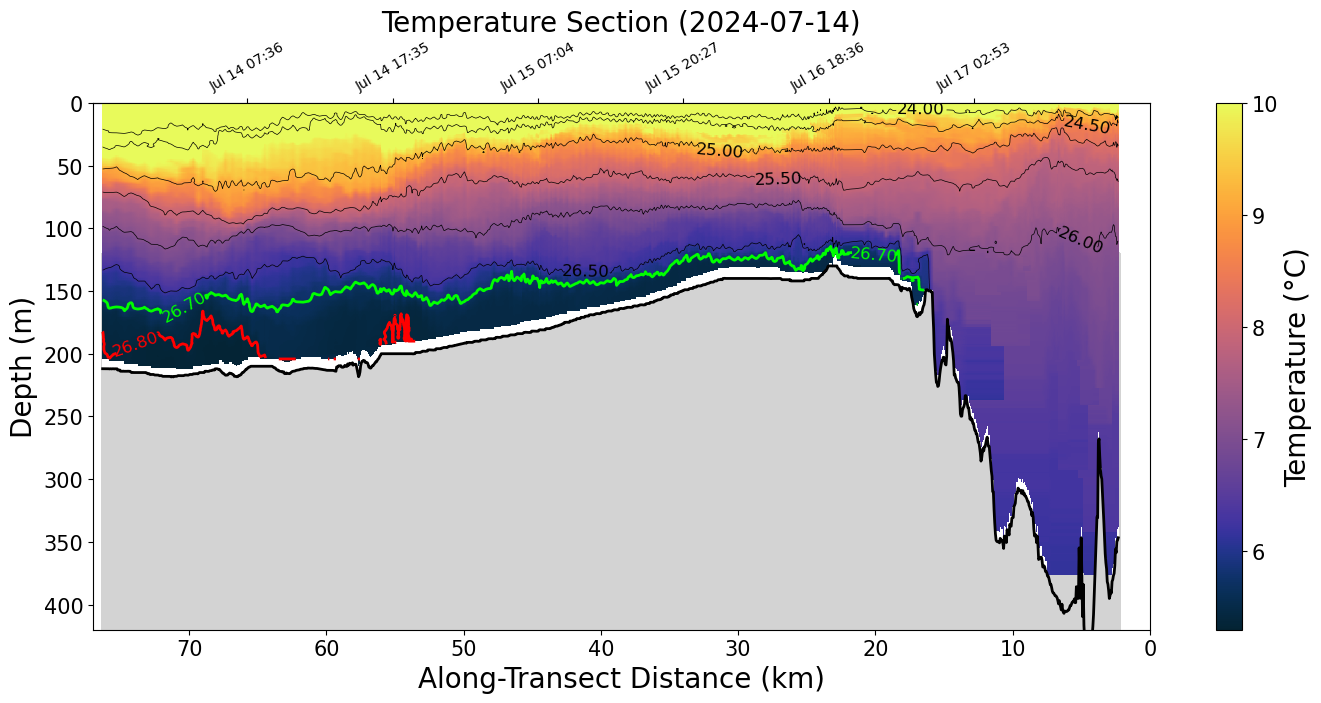

In [77]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import waypoint_distance as wd
import pandas as pd

def plot_section(ds, xlim=(77,0)):
    """
    Plot temperature section for a given file

    Parameters:
    - ds: xarray.Dataset, a .nc file for each transect
    - xlim: float, maximum distance (km) along transect to plot
    """

    # ─── Styling ─────────────────────────────────────────
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    # ─── Load Bathymetry ────────────────────────────────
    topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
    topo = xr.open_dataset(topo_file)

    # ─── Extract variables ──────────────────────────────
    along = ds['along'].values
    depth = ds['depth'].values
    temperature = ds['temperature'].values
    pdens = ds['potential_density'].values - 1000  # sigma-theta
    lon = ds['longitude'].values
    lat = ds['latitude'].values
    time_top = ds['time'].values  # shape (along,)



    # # ------------- TRYING SOME MASKING ____________####
    # # ─── Mask unrealistic vertical density gradients ──────
    # d_sigma_dz = np.gradient(pdens, depth, axis=0)  # shape: (depth, along)

    # # Set up mask: True where gradient is unstable (negative and steep)
    # bad_grad_mask = d_sigma_dz < -0.1  # shape: (depth, along)

    # # For each along-column, find first bad gradient, mask everything deeper
    # for j in range(bad_grad_mask.shape[1]):  # loop over along dimension
    #     bad_indices = np.where(bad_grad_mask[:, j])[0]
    #     if bad_indices.size > 0:
    #         first_bad = bad_indices[0]
    #         temperature[first_bad:, j] = np.nan
    #         pdens[first_bad:, j] = np.nan

    # # Another mask attempt #: 
    # # # ─── Mask using recorded valid temperature depth ───────
    # # ─── Smoothed Depth Mask based on Original Valid Data ──────


    # ─── Global Clearance-Based Depth Mask ──────
    if 'valid_temp_depth' in ds:
        # Interpolate bathymetry
        ocean_floor = -topo['Band1'].interp(
            lon=xr.DataArray(lon, dims='along'),
            lat=xr.DataArray(lat, dims='along'),
            method='nearest').values

        valid_depths = ds['valid_temp_depth'].values

        # Compute local clearance
        local_clearance = ocean_floor - valid_depths

        # Average clearance in trusted region (20–77 km)
        trusted = (along >= 20000) & (along <= 77000)
        mean_clearance = np.nanmean(local_clearance[trusted])

        # Compute final mask depth (adaptive)
        mask_depth = np.minimum(
            np.where(local_clearance <= mean_clearance,
                    ocean_floor - local_clearance,
                    ocean_floor - mean_clearance),
            ocean_floor
        )

        # Apply the depth mask to temperature and density
        for j in range(len(along)):
            limit_depth = mask_depth[j]

            if np.isnan(limit_depth):
                temperature[:, j] = np.nan
                pdens[:, j] = np.nan
            else:
                deep_mask = depth > limit_depth
                temperature[deep_mask, j] = np.nan
                pdens[deep_mask, j] = np.nan
    ######### --------------------------------------------------__#########



    # ─── Interpolate Bathymetry ─────────────────────────
    interp_bathy = topo['Band1'].interp(
        lon=xr.DataArray(lon, dims='along'),
        lat=xr.DataArray(lat, dims='along'),
        method='nearest')
    ocean_floor = -interp_bathy.values
    below_ocean_floor= np.linspace(120, 420, 301)
    depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')
    below_ocean_floor_grid, along_grid_bathy = np.meshgrid(below_ocean_floor, along, indexing='ij')
    valid_region_for_temp = (depth_grid <= ocean_floor)
    valid_region_for_bathy = (below_ocean_floor_grid <= ocean_floor)

    depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')  # (378, 1498)
    # ─── White zone between adaptive mask and ocean floor ─────
    between_mask_and_floor = ((depth_grid <= ocean_floor) & np.isnan(temperature))
    white_patch = np.where(between_mask_and_floor, 1, np.nan)

    # ─── Plot ───────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))

    print(along_grid.shape, depth_grid.shape, white_patch.shape)

    # Plot white background for that zone
    ax.pcolormesh(along_grid / 1000, depth_grid, white_patch,
              cmap='gray', shading='auto', vmin=0, vmax=1, zorder=0)

    # Mask temperature below bathymetry
    temperature_masked = np.where(valid_region_for_temp, temperature, np.nan)
    pdens_masked = np.where(valid_region_for_temp, pdens, np.nan)

    # Grey zone below seafloor
    ax.pcolormesh(along_grid_bathy / 1000, below_ocean_floor_grid,
              np.where(valid_region_for_bathy, np.nan, 1),
              color='lightgrey', shading='auto', vmin=0, vmax=1, zorder=-1)
    
    # Plot masked temperature field
    cf = ax.pcolormesh(along / 1000, depth, temperature_masked, 
                    shading='auto', cmap=cm.cm.thermal, 
                    vmin=5.3, vmax=10, zorder=2)

    # Plot bathymetry
    ax.plot(along / 1000, ocean_floor, color='black', linewidth=2)

    # Isopycnals
    for levels, color, lw in [
        (np.linspace(24, 27, 7), 'black', 0.5),
        # ([26.6], 'white', 2),
        ([26.7], 'lime', 2),
        ([26.8], 'red', 2),
        ([26.9], 'blue', 2)]:
        cf_iso = ax.contour(along / 1000, depth, pdens_masked, levels=levels,
                            colors=color, linewidths=lw, linestyles='-')
        if lw != 0.3:
            ax.clabel(cf_iso, fmt='%1.2f')

    # ─── Top Axis with Time Labels ──────────────────────
    along_km = along / 1000
    nticks = 8
    idx_ticks = np.linspace(0, len(along_km) - 1, nticks, dtype=int)
    tick_locs = along_km[idx_ticks]
    tick_times = time_top[idx_ticks]

    # Remove NaT
    valid_mask = ~pd.isna(tick_times)
    tick_locs = tick_locs[valid_mask]
    tick_times = tick_times[valid_mask]
    tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(tick_locs)
    ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

    # ─── Labels and Limits ──────────────────────────────
    ax.set_xlabel('Along-Transect Distance (km)')
    ax.set_ylabel('Depth (m)')
    ax.invert_yaxis()
    ax.set_ylim(420, 0)
    ax.set_xlim(xlim)

    earliest_time = pd.to_datetime(min(tick_times))
    tstr = earliest_time.strftime('%Y-%m-%d')
    ax.set_title(f'Temperature Section ({tstr})')

    plt.colorbar(cf, ax=ax, label='Temperature (°C)')
    plt.tight_layout()

def interpolate(ds, step=50, extrapolate=True):
    import numpy as np
    import xarray as xr

    # Remove duplicate along values
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)

    # Build regular along grid
    min_along = np.floor(ds['along'].min().item() / step) * step
    max_along = np.ceil(ds['along'].max().item() / step) * step
    along_grid = np.arange(min_along, max_along + 1, step)

    # Swap time with along for interpolation
    ds = ds.swap_dims({'time': 'along'})
    ds_interp = ds.interp(along=along_grid)

    # Interpolate time manually (since it's not numeric by default)
    interp_time = np.interp(
        along_grid,
        ds['along'].values,
        ds['time'].values.astype('datetime64[ns]').astype('float64'),
        left=np.nan,
        right=np.nan
    )
    ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

    # Get along mask for 0–20 km region
    mask_along = (ds_interp['along'] >= 0) & (ds_interp['along'] <= 20000)

    # Subset temperature in that range
    temp_sub = ds_interp['temperature'].where(mask_along, drop=True)

    # Find the deepest depth where at least one valid (non-NaN) temperature exists
    valid_depths = ds_interp['depth'][~np.all(np.isnan(temp_sub), axis=1)]
    max_valid_depth = valid_depths.max().item()

    # Limit to valid depth range
    ds_interp = ds_interp.sel(depth=ds_interp['depth'] <= max_valid_depth)

    # ─── Vectorized valid_temp_depth assignment ─────
    temp = ds_interp['temperature'].values  # (depth, along)
    depth_vals = ds_interp['depth'].values
    valid_mask = ~np.isnan(temp)
    reversed_mask = valid_mask[::-1, :]
    first_valid_idx_from_bottom = reversed_mask.argmax(axis=0)
    has_valid_data = valid_mask.any(axis=0)
    valid_depths = np.where(has_valid_data,
                            depth_vals[-1 - first_valid_idx_from_bottom],
                            np.nan)
    ds_interp['valid_temp_depth'] = ('along', valid_depths)

    # ─── Fill NaNs along each depth row using nearest ─────
    for var in ds_interp.data_vars:
        da = ds_interp[var]
        if 'along' not in da.dims or 'depth' not in da.dims:
            continue

        filled_rows = []
        depths = ds_interp['depth'].values
        along_vals = ds_interp['along'].values

        for i in range(len(depths)):
            row = da.isel(depth=i)
            filled = row.interpolate_na(
                dim='along',
                method='nearest',
                fill_value='extrapolate')
            filled_rows.append(filled.values)

        # Rebuild variable
        new_da = xr.DataArray(
            data=np.array(filled_rows),
            dims=('depth', 'along'),
            coords={'depth': depths, 'along': along_vals})
        ds_interp[var] = new_da

    return ds_interp

if True:
    # file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
    # file_pathway = '~/CalvertLine_reprocessed/dfo-eva035-20230811_grid_delayed.nc'
    # file_pathway = '~/CalvertLine_reprocessed/dfo-eva035-20231019_grid_delayed.nc'
    file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20240702_grid_delayed.nc'
    # file_pathway = '~/Desktop/dfo-hal1002-20250506_grid.nc'

    ds = xr.open_dataset(file_pathway)

    waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
    waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
    central_lat = 51.715

    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat)

    ds = ds.assign(along=('time', alongx), across=('time', acrossx))

    peak_idx = int(np.argmax(ds['along'].values))
    ds_out = ds.isel(time=slice(0, peak_idx + 1))
    ds_return = ds.isel(time=slice(peak_idx + 1, None))

    results = {}

    for leg, name in [(ds_out, "out"), (ds_return, "return")]:
        try:
            if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
                continue

            prev_len = -1
            while prev_len != len(leg['time']):
                if len(leg['along']) < 3:
                    raise ValueError("Too short for gradient")
                prev_len = len(leg['time'])
                grad = np.gradient(leg['along'].values)
                keep_mask = grad > 0 if name == "out" else grad < 0
                leg = leg.sel(time=keep_mask)

            if np.count_nonzero(~np.isnan(leg['along'])) < 100:
                continue

            # Interpolate before assigning to results
            leg_interp = interpolate(leg, step=50)
            results[name] = leg_interp
            # results[name] = leg

        except Exception as e:
            print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
            continue

# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

# Example: plot outbound leg
if ds_out_cleaned is not None:
    plot_section(ds_out_cleaned)
    plt.show()
else:
    print("No outbound leg found.")

# Example: plot return leg
if ds_return_cleaned is not None:
    plot_section(ds_return_cleaned)
    plt.show()
else:
    print("No return leg found.")

/var/folders/w3/xmmx3z314913xcdb0jf7m8h40000gn/T/ipykernel_1208/1755936444.py:236: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for j in range(ds_interp.dims['along']):
/var/folders/w3/xmmx3z314913xcdb0jf7m8h40000gn/T/ipykernel_1208/1755936444.py:236: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for j in range(ds_interp.dims['along']):


(359, 1519) (359, 1519) (359, 1519)


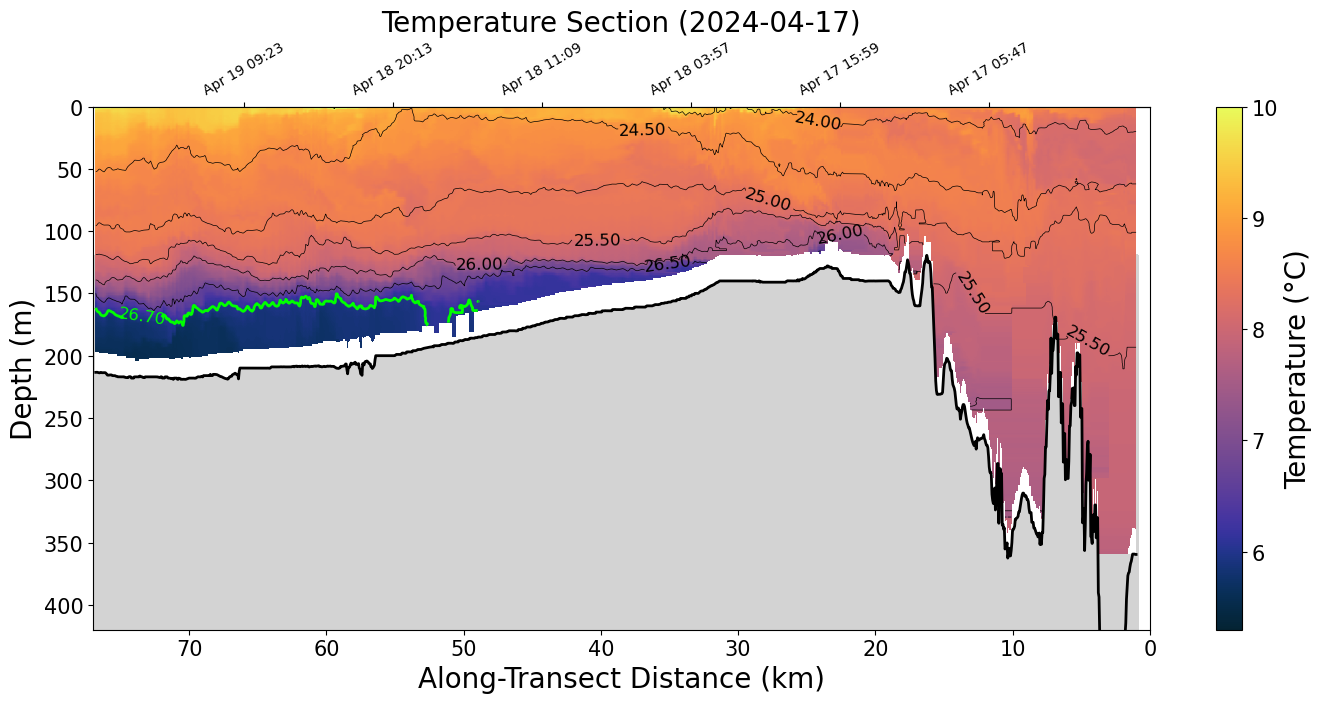

(409, 1504) (409, 1504) (409, 1504)


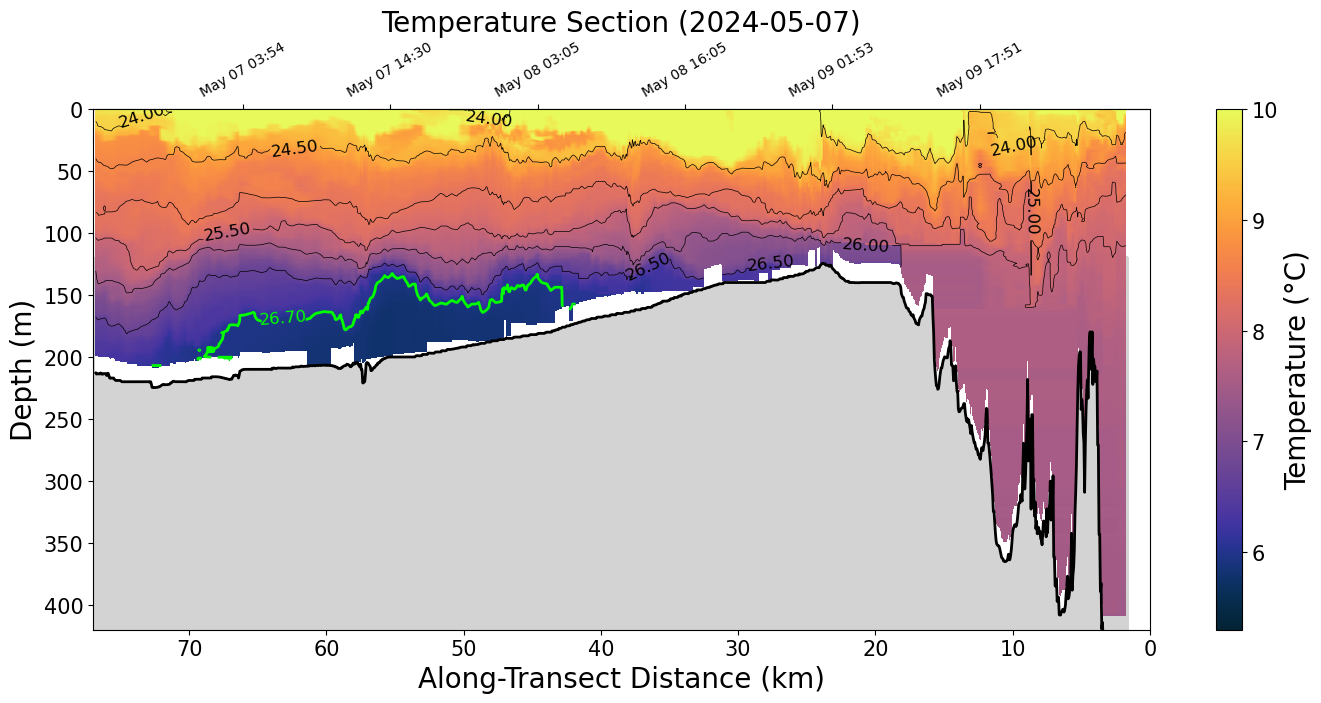

In [75]:

if True:
    file_pathway = '~/CalvertLine_reprocessed/dfo-marvin1003-20240416_grid_delayed.nc'

    ds = xr.open_dataset(file_pathway)

    waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
    waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
    central_lat = 51.715

    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat)

    ds = ds.assign(along=('time', alongx), across=('time', acrossx))

    peak_idx = int(np.argmax(ds['along'].values))
    ds_out = ds.isel(time=slice(0, peak_idx + 1))
    ds_return = ds.isel(time=slice(peak_idx + 1, None))

    results = {}

    for leg, name in [(ds_out, "out"), (ds_return, "return")]:
        try:
            if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
                continue

            prev_len = -1
            while prev_len != len(leg['time']):
                if len(leg['along']) < 3:
                    raise ValueError("Too short for gradient")
                prev_len = len(leg['time'])
                grad = np.gradient(leg['along'].values)
                keep_mask = grad > 0 if name == "out" else grad < 0
                leg = leg.sel(time=keep_mask)

            if np.count_nonzero(~np.isnan(leg['along'])) < 100:
                continue

            # ✅ Interpolate before assigning to results
            leg_interp = interpolate(leg, step=50)
            results[name] = leg_interp
            # results[name] = leg

        except Exception as e:
            print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
            continue

# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

# Example: plot outbound leg
if ds_out_cleaned is not None:
    plot_section(ds_out_cleaned)
    plt.show()
else:
    print("No outbound leg found.")

# Example: plot return leg
if ds_return_cleaned is not None:
    plot_section(ds_return_cleaned)
    plt.show()
else:
    print("No return leg found.")

# BELOW THIS WE DON'T WANT TO USE ANYMORE, HERE IN CASE I EVER NEED IT

# Trying to see if the gradient is a good way to mask? # 
I think not since it tends to remove some of the extrapolated values that I do want.

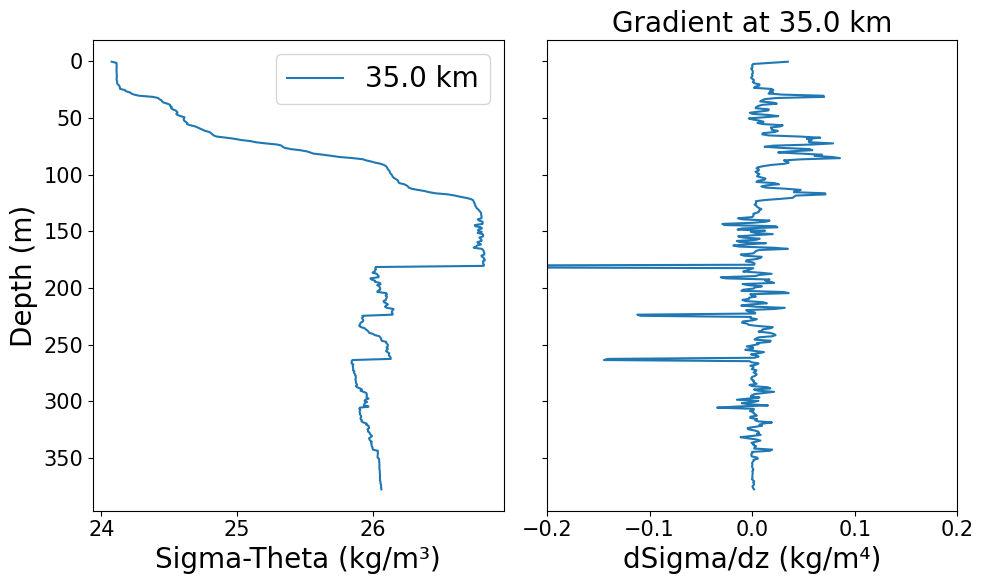

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a dataset and fixed along distances (in meters)
ds = ds_return_cleaned  # or ds_return_cleaned
target_alongs = [35000]  # example fixed distances in meters

# Extract coordinates
depths = ds['depth'].values
along = ds['along'].values

# Loop over selected along distances
for target in target_alongs:
    # Find index of closest along value
    idx = np.argmin(np.abs(along - target))

    # Get the sigma-theta profile at that along position
    sigma = ds['potential_density'].isel(along=idx).values - 1000  # sigma-theta
    z = depths

    # Compute vertical gradient (∂σ/∂z)
    d_sigma_dz = np.gradient(sigma, z)

    # Plot both
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    
    ax[0].plot(sigma, z, label=f'{target/1000:.1f} km')
    ax[0].invert_yaxis()
    ax[0].set_xlabel('Sigma-Theta (kg/m³)')
    ax[0].set_ylabel('Depth (m)')
    ax[0].legend()
    
    ax[1].plot(d_sigma_dz, z)
    # ax[1].invert_yaxis()
    ax[1].set_xlabel('dSigma/dz (kg/m⁴)')
    ax[1].set_title(f'Gradient at {target/1000:.1f} km')
    ax[1].set_xlim(-0.2, 0.2)

    plt.tight_layout()

# Testing interpolate function

In [ ]:
if True:
    file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
    # file_pathway = '~/Desktop/dfo-hal1002-20250506_grid.nc'
    ds = xr.open_dataset(file_pathway)

    waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
    waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
    central_lat = 51.715

    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat)

    ds = ds.assign(along=('time', alongx), across=('time', acrossx))

    peak_idx = int(np.argmax(ds['along'].values))
    ds_out = ds.isel(time=slice(0, peak_idx + 1))
    ds_return = ds.isel(time=slice(peak_idx + 1, None))

    results = {}

    for leg, name in [(ds_out, "out"), (ds_return, "return")]:
        try:
            if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
                continue

            prev_len = -1
            while prev_len != len(leg['time']):
                if len(leg['along']) < 3:
                    raise ValueError("Too short for gradient")
                prev_len = len(leg['time'])
                grad = np.gradient(leg['along'].values)
                keep_mask = grad > 0 if name == "out" else grad < 0
                leg = leg.sel(time=keep_mask)

            if np.count_nonzero(~np.isnan(leg['along'])) < 100:
                continue

            # ✅ Interpolate before assigning to results
            # leg_interp = interpolate(leg, step=50)
            results[name] = leg

        except Exception as e:
            print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
            continue
# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

ds = ds_return_cleaned
step = 50
import numpy as np
import xarray as xr

# Remove duplicate along values
_, index_unique = np.unique(ds['along'], return_index=True)
ds = ds.isel(time=index_unique)

# Build regular along grid
min_along = np.floor(ds['along'].min().item() / step) * step
max_along = np.ceil(ds['along'].max().item() / step) * step
along_grid = np.arange(min_along, max_along + 1, step)

# Swap time with along for interpolation
ds = ds.swap_dims({'time': 'along'})
ds_interp = ds.interp(along=along_grid)

# Interpolate time manually
interp_time = np.interp(
    along_grid,
    ds['along'].values,
    ds['time'].values.astype('datetime64[ns]').astype('float64'),
    left=np.nan,
    right=np.nan
)
ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

# Get along mask for 0–20 km
mask_along = (ds_interp['along'] >= 0) & (ds_interp['along'] <= 20000)

# Subset temp data in that along range
temp_sub = ds_interp['temperature'].where(mask_along, drop=True)

# Find the deepest depth where there's at least one valid (non-NaN) temperature
valid_depths = ds_interp['depth'][~np.all(np.isnan(temp_sub), axis=1)]
max_valid_depth = valid_depths.max().item()

# Now limit dataset to just that depth range
ds_interp = ds_interp.sel(depth=ds_interp['depth'] <= max_valid_depth)

# Fill NaNs along 'along', one depth at a time using nearest
for var in ds_interp.data_vars:
    da = ds_interp[var]
    if 'along' not in da.dims or 'depth' not in da.dims:
        continue  # skip 1D or unrelated variables

    filled_rows = []
    depths = ds_interp['depth'].values
    along_vals = ds_interp['along'].values

    for i in range(len(depths)):
        row = da.isel(depth=i)

        filled = row.interpolate_na(
            dim='along',
            method='nearest',
            fill_value='extrapolate')
        filled_rows.append(filled.values)

    # Rebuild filled variable
    new_da = xr.DataArray(
        data=np.array(filled_rows),
        dims=('depth', 'along'),
        coords={'depth': depths, 'along': along_vals})
    ds_interp[var] = new_da

array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
        45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
        54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
        63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
        72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
        81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
        90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
        99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
       108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
       117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
       126.5, 127.5,

In [6]:
# file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
# ds = xr.open_dataset(file_pathway)

# waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
# waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
# central_lat = 51.715

# alongx, acrossx, _ = wd.get_simple_distance(
#     shiplon=ds['longitude'].values,
#     shiplat=ds['latitude'].values,
#     wplon=waypoint_lon,
#     wplat=waypoint_lat,
#     central_lat=central_lat)

# ds = ds.assign(along=('time', alongx), across=('time', acrossx))

# peak_idx = int(np.argmax(ds['along'].values))
# ds_out = ds.isel(time=slice(0, peak_idx + 1))
# ds_return = ds.isel(time=slice(peak_idx + 1, None))

# results = {}

# for leg, name in [(ds_out, "out"), (ds_return, "return")]:
#     try:
#         if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
#             continue

#         prev_len = -1
#         while prev_len != len(leg['time']):
#             if len(leg['along']) < 3:
#                 raise ValueError("Too short for gradient")
#             prev_len = len(leg['time'])
#             grad = np.gradient(leg['along'].values)
#             keep_mask = grad > 0 if name == "out" else grad < 0
#             leg = leg.sel(time=keep_mask)

#         if np.count_nonzero(~np.isnan(leg['along'])) < 100:
#             continue

#         # ✅ Interpolate before assigning to results
#         leg_interp = interpolate(leg, step=50)
#         results[name] = leg_interp

#     except Exception as e:
#         print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
#         continue

# # Check what made it into results
# print(results.keys())  # Should show 'out', 'return' if both passed

# # Access outbound leg
# ds_out_cleaned = results.get("out")

# # Access return leg
# ds_return_cleaned = results.get("return")

# # Example: plot outbound leg
# if ds_out_cleaned is not None:
#     plot_section(ds_out_cleaned)
#     plt.show()
# else:
#     print("No outbound leg found.")

# # Example: plot return leg
# if ds_return_cleaned is not None:
#     plot_section(ds_return_cleaned)
#     plt.show()
# else:
#     print("No return leg found.")

# def plot_section_scatter(ds, xlim = 77):
#     """
#     Plot temperature section for a given file

#     Parameters:
#     - ds: xarray.Dataset, a .nc file for each transect
#     - temp_bounds: tuple, (min, max) temperature values for colormap.
#     """

#     plt.rcParams.update({
#         'font.size': 12,
#         'axes.titlesize': 20,
#         'axes.labelsize': 20,
#         'xtick.labelsize': 15,
#         'ytick.labelsize': 15,
#         'legend.fontsize': 20,
#         'figure.titlesize': 20})
    
#     topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
#     topo = xr.open_dataset(topo_file)
#     ds = ds
#     temp_bounds = (5.3, 10)
#     # Extract coordinates and data
#     along = ds['along'].values
#     depth = ds['depth'].values
#     temperature = ds['temperature'].values
#     pdens = ds['potential_density'].values - 1000  # Sigma-theta

#     # Interpolate bathymetry over full along track
#     full_lon = ds['longitude'].values
#     full_lat = ds['latitude'].values

#     interp_bathy = topo['Band1'].interp(
#         lon=xr.DataArray(full_lon, dims='along'),
#         lat=xr.DataArray(full_lat, dims='along'),
#         method='nearest')
#     bottom_depths = -interp_bathy.values  # 1D array for full along

#     # Plot temperature section
#     fig, ax = plt.subplots(figsize=( 1.5 * 1.5 * 6.4, 1.5 * 4.8))
#     # Create meshgrid of depth and along
#     depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')

#     # Expand bottom_depths to match depth grid shape
#     bathymetry_floor = np.tile(bottom_depths, (len(depth), 1))

#     # Create mask where depth > bottom
#     mask = depth_grid > bathymetry_floor

#     # Plot grey background
#     ax.contourf(along / 1000, depth, mask,
#                 levels=[0.5, 1.5], colors='grey', zorder=1)
#     # cf = ax.pcolormesh(along / 1000, depth, temperature, shading='auto',
#     #                     cmap=cm.cm.thermal, vmin=temp_bounds[0], vmax=temp_bounds[1])
#     depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')

#     ax.scatter(along_grid.flatten() / 1000, depth_grid.flatten(), 
#             c=temperature.flatten(), cmap=cm.cm.thermal,
#             s=2, marker='.', alpha=0.7)
        
#     # Bathymetry
#     ax.plot(along / 1000, bottom_depths, color='black', linewidth=2)

#     # Isopycnal contours
#     for levels, color, lw in [
#         (np.linspace(24, 27, 7), 'black', 0.5),
#         ([26.6], 'white', 2),
#         ([26.7], 'lime', 2),
#         ([26.8], 'red', 2),
#         ([26.9], 'blue', 2)]:
#         cf_iso = ax.contour(along / 1000, depth, pdens, levels=levels,
#                             colors=color, linewidths=lw, linestyles='-')
#         if lw != 0.3:
#             ax.clabel(cf_iso, fmt='%1.2f')

#     time_top = ds['time'].values  # shape (along,)
#     along_km = along / 1000

#     # Number of ticks you want
#     nticks = 8
#     idx_ticks = np.linspace(0, len(along_km) - 1, nticks, dtype=int)

#     tick_locs = along_km[idx_ticks]
#     tick_times = time_top[idx_ticks]

#     # Remove NaT values
#     valid_mask = ~pd.isna(tick_times)
#     tick_locs = tick_locs[valid_mask]
#     tick_times = tick_times[valid_mask]

#     # Format with hour and date
#     tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

#     # Add secondary x-axis with formatted time ticks
#     ax_top = ax.secondary_xaxis('top')
#     ax_top.set_xticks(tick_locs)
#     ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

#     # Labels and formatting
#     ax.set_xlabel('Along-Transect Distance (km)')
#     ax.set_ylabel('Depth (m)')
#     ax.invert_yaxis()
#     ax.set_ylim(410, 0)
#     ax.set_xlim(xlim,0)
#     earliest_time = pd.to_datetime(min(tick_times))
#     tstr = earliest_time.strftime('%Y-%m-%d')
#     ax.set_title(f'Temperature Section ({tstr})')
#     # plt.colorbar(cf, ax=ax, label='Temperature (°C)')
#     plt.tight_layout()

In [7]:
# plot_section(ds_return_cleaned)
# plot_section_scatter(ds_return_cleaned)

# this one below works pretty well, full workflow: #

⚠️ Skipping return leg in ~/Desktop/dfo-hal1002-20250506_grid.nc: Too short for gradient
dict_keys(['out'])


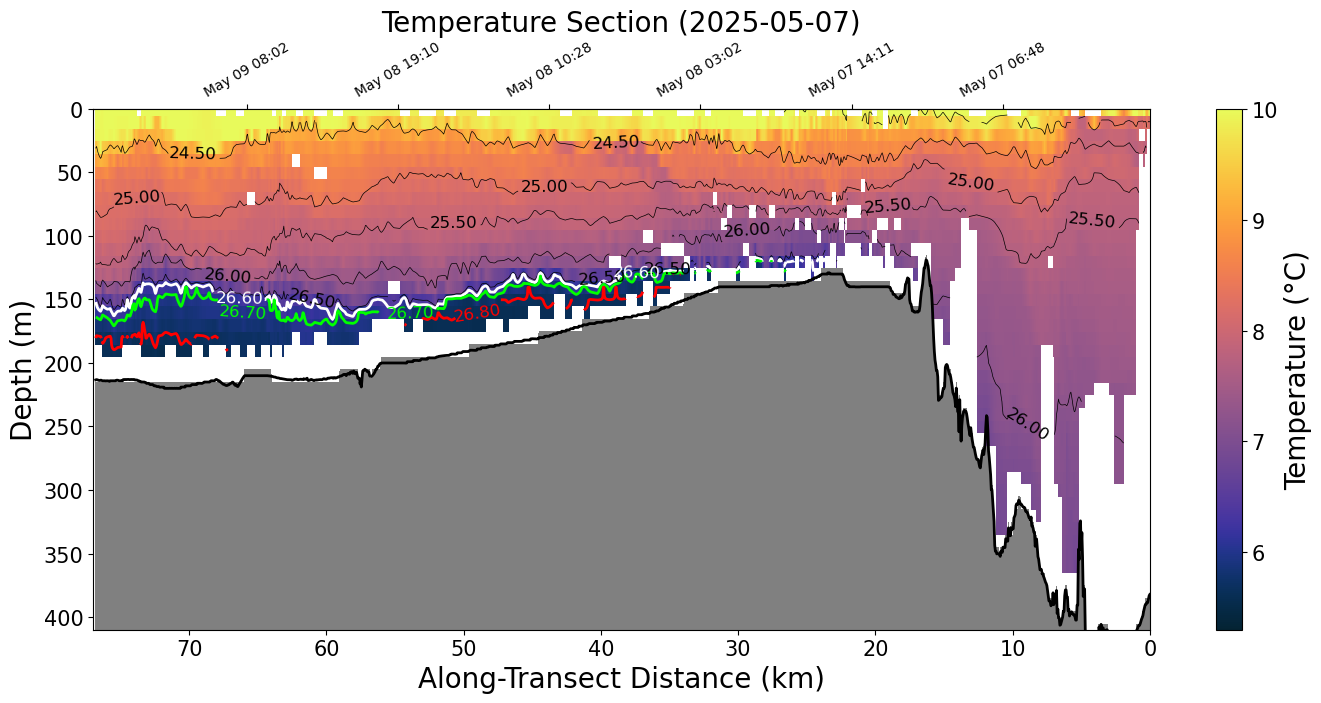

No return leg found.


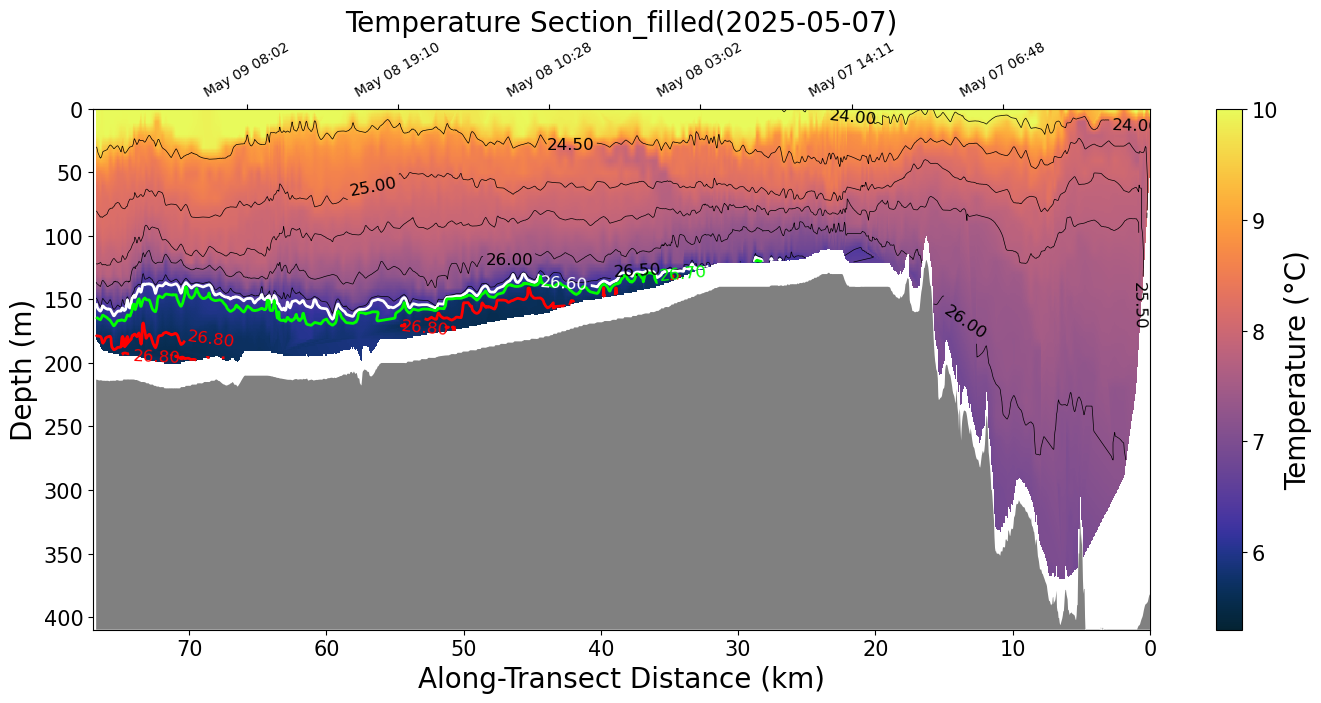

In [14]:
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import waypoint_distance as wd
import pandas as pd

def interpolate(ds, step=50):
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)

    min_along = np.floor(ds['along'].min().item() / step) * step
    max_along = np.ceil(ds['along'].max().item() / step) * step
    along_grid = np.arange(min_along, max_along + 1, step)

    ds = ds.swap_dims({'time': 'along'})
    ds_interp = ds.interp(along=along_grid)

    interp_time = np.interp(
        along_grid,
        ds['along'].values,
        ds['time'].values.astype('datetime64[ns]').astype('float64'),
        left=np.nan,
        right=np.nan
    )
    ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

    return ds_interp

file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
file_pathway = '~/Desktop/dfo-hal1002-20250506_grid.nc'
ds = xr.open_dataset(file_pathway)

waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
central_lat = 51.715

alongx, acrossx, _ = wd.get_simple_distance(
    shiplon=ds['longitude'].values,
    shiplat=ds['latitude'].values,
    wplon=waypoint_lon,
    wplat=waypoint_lat,
    central_lat=central_lat)

ds = ds.assign(along=('time', alongx), across=('time', acrossx))

peak_idx = int(np.argmax(ds['along'].values))
ds_out = ds.isel(time=slice(0, peak_idx + 1))
ds_return = ds.isel(time=slice(peak_idx + 1, None))

results = {}

for leg, name in [(ds_out, "out"), (ds_return, "return")]:
    try:
        if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
            continue

        prev_len = -1
        while prev_len != len(leg['time']):
            if len(leg['along']) < 3:
                raise ValueError("Too short for gradient")
            prev_len = len(leg['time'])
            grad = np.gradient(leg['along'].values)
            keep_mask = grad > 0 if name == "out" else grad < 0
            leg = leg.sel(time=keep_mask)

        if np.count_nonzero(~np.isnan(leg['along'])) < 100:
            continue

        # ✅ Interpolate before assigning to results
        leg_interp = interpolate(leg, step=50)
        results[name] = leg_interp

    except Exception as e:
        print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
        continue

# Check what made it into results
print(results.keys())  # Should show 'out', 'return' if both passed

# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

# Example: plot outbound leg
if ds_out_cleaned is not None:
    plot_section(ds_out_cleaned)
    plt.show()
else:
    print("No outbound leg found.")

# Example: plot return leg
if ds_return_cleaned is not None:
    plot_section(ds_return_cleaned)
    plt.show()
else:
    print("No return leg found.")

def plot_section_gridded(ds, xlim=77):

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    # Load bathymetry
    topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
    topo = xr.open_dataset(topo_file)
    temp_bounds = (5.3, 10)

    # Extract data
    along = ds['along'].values
    depth = ds['depth'].values
    temp = ds['temperature'].values
    pdens = ds['potential_density'].values - 1000
    lon = ds['longitude'].values
    lat = ds['latitude'].values

    # Bathymetry along track
    bottom_depths = -topo['Band1'].interp(
        lon=xr.DataArray(lon, dims='along'),
        lat=xr.DataArray(lat, dims='along'),
        method='nearest').values  # positive downward

    # Grids
    along_grid_m = np.linspace(np.nanmin(along), np.nanmax(along), 2000)
    along_grid_km = along_grid_m / 1000
    depth_grid = np.linspace(np.nanmin(depth), np.nanmax(depth), 1000)
    A, D = np.meshgrid(along_grid_m, depth_grid)

    # Interpolate bathymetry early
    bathy_interp = np.interp(along_grid_km, along / 1000, bottom_depths)
    bathy_floor = np.tile(bathy_interp, (depth_grid.size, 1))

    # Interpolation: temperature
    xx, zz = np.meshgrid(along, depth, indexing='ij')
    points = np.column_stack((xx.ravel(), zz.ravel()))
    values = temp.T.ravel()
    mask = ~np.isnan(values)
    # Restrict interpolation to above bathymetry
    valid_region = D <= bathy_floor - 19
    interp_points = np.column_stack((A[valid_region], D[valid_region]))

    temp_interp_values = griddata(points[mask], values[mask], interp_points, method='linear')

    temp_masked = np.full_like(A, np.nan)
    temp_masked[valid_region] = temp_interp_values

    # Interpolation: potential density
    # Flatten potential density
    values_dens = pdens.T.ravel()
    mask_dens = ~np.isnan(values_dens)

    # Define valid interpolation region (above seafloor only)
    valid_region = D <= bathy_floor - 19
    interp_points_dens = np.column_stack((A[valid_region], D[valid_region]))

    # Interpolate ONLY above bathymetry
    pdens_interp_values = griddata(
        points[mask_dens],
        values_dens[mask_dens],
        interp_points_dens,
        method='linear'
    )

    # Reconstruct full 2D array
    pdens_masked = np.full_like(A, np.nan)
    pdens_masked[valid_region] = pdens_interp_values

    # Plot
    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))

    # Temperature
    cf = ax.pcolormesh(along_grid_km, depth_grid, temp_masked,
                       shading='auto', cmap=cm.cm.thermal,
                       vmin=temp_bounds[0], vmax=temp_bounds[1])
    
    # Bathymetry fill
    ax.fill_between(along_grid_km, bathy_interp, 410, facecolor='grey', zorder=5)

    # Isopycnals
    for levels, color, lw in [
        (np.linspace(24, 27, 7), 'black', 0.5),
        # ([25.6], 'black', 0.5),
        # ([25.7], 'black', 0.5),
        # ([25.8], 'black', 0.5),
        # ([25.75], 'black', 0.3),
        ([26.6], 'white', 2),
        ([26.7], 'lime', 2),
        ([26.8], 'red', 2),
        ([26.9], 'blue', 2)]:
        iso = ax.contour(along_grid_km, depth_grid, pdens_masked, levels=levels,
                        colors=color, linewidths=lw)
        if lw != 0.3:
            ax.clabel(iso, fmt='%1.2f')

    # Time ticks on top
    time = ds['time'].values
    along_km = along / 1000
    nticks = 8
    idx = np.linspace(0, len(along_km) - 1, nticks, dtype=int)
    tick_locs = along_km[idx]
    tick_times = time[idx]
    valid = ~pd.isna(tick_times)
    tick_locs = tick_locs[valid]
    tick_times = tick_times[valid]
    tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(tick_locs)
    ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

    # Labels & layout
    ax.set_xlabel('Along-Transect Distance (km)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(xlim, 0)
    ax.set_ylim(410, 0)
    ax.set_title(f"Temperature Section_filled({pd.to_datetime(tick_times[0]).strftime('%Y-%m-%d')})")
    plt.colorbar(cf, ax=ax, label='Temperature (°C)')
    plt.tight_layout()
    plt.show()

plot_section_gridded(ds_out_cleaned)

In [9]:
# def plot_section_scatter(ds, xlim = 77):
#     """
#     Plot temperature section for a given file

#     Parameters:
#     - ds: xarray.Dataset, a .nc file for each transect
#     - temp_bounds: tuple, (min, max) temperature values for colormap.
#     """

#     plt.rcParams.update({
#         'font.size': 12,
#         'axes.titlesize': 20,
#         'axes.labelsize': 20,
#         'xtick.labelsize': 15,
#         'ytick.labelsize': 15,
#         'legend.fontsize': 20,
#         'figure.titlesize': 20})
    
#     topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
#     topo = xr.open_dataset(topo_file)
#     ds = ds
#     temp_bounds = (5.3, 10)
#     # Extract coordinates and data
#     along = ds['along'].values
#     depth = ds['depth'].values
#     temperature = ds['temperature'].values
#     pdens = ds['potential_density'].values - 1000  # Sigma-theta

#     # Interpolate bathymetry over full along track
#     full_lon = ds['longitude'].values
#     full_lat = ds['latitude'].values

#     interp_bathy = topo['Band1'].interp(
#         lon=xr.DataArray(full_lon, dims='along'),
#         lat=xr.DataArray(full_lat, dims='along'),
#         method='nearest')
#     bottom_depths = -interp_bathy.values  # 1D array for full along

#     # Plot temperature section
#     fig, ax = plt.subplots(figsize=( 1.5 * 1.5 * 6.4, 1.5 * 4.8))
#     # Create meshgrid of depth and along
#     depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')

#     # Expand bottom_depths to match depth grid shape
#     bathymetry_floor = np.tile(bottom_depths, (len(depth), 1))

#     # Create mask where depth > bottom
#     mask = depth_grid > bathymetry_floor

#     # Plot grey background
#     ax.contourf(along / 1000, depth, mask,
#                 levels=[0.5, 1.5], colors='grey', zorder=1)
#     # cf = ax.pcolormesh(along / 1000, depth, temperature, shading='auto',
#     #                     cmap=cm.cm.thermal, vmin=temp_bounds[0], vmax=temp_bounds[1])
#     depth_grid, along_grid = np.meshgrid(depth, along, indexing='ij')

#     ax.scatter(along_grid.flatten() / 1000, depth_grid.flatten(), 
#             c=temperature.flatten(), cmap=cm.cm.thermal,
#             s=2, marker='.', alpha=0.7)
        
#     # Bathymetry
#     ax.plot(along / 1000, bottom_depths, color='black', linewidth=2)

#     # Isopycnal contours
#     for levels, color, lw in [
#         (np.linspace(24, 27, 7), 'black', 0.5),
#         ([26.6], 'white', 2),
#         ([26.7], 'lime', 2),
#         ([26.8], 'red', 2),
#         ([26.9], 'blue', 2)]:
#         cf_iso = ax.contour(along / 1000, depth, pdens, levels=levels,
#                             colors=color, linewidths=lw, linestyles='-')
#         if lw != 0.3:
#             ax.clabel(cf_iso, fmt='%1.2f')

#     time_top = ds['time'].values  # shape (along,)
#     along_km = along / 1000

#     # Number of ticks you want
#     nticks = 8
#     idx_ticks = np.linspace(0, len(along_km) - 1, nticks, dtype=int)

#     tick_locs = along_km[idx_ticks]
#     tick_times = time_top[idx_ticks]

#     # Remove NaT values
#     valid_mask = ~pd.isna(tick_times)
#     tick_locs = tick_locs[valid_mask]
#     tick_times = tick_times[valid_mask]

#     # Format with hour and date
#     tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

#     # Add secondary x-axis with formatted time ticks
#     ax_top = ax.secondary_xaxis('top')
#     ax_top.set_xticks(tick_locs)
#     ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

#     # Labels and formatting
#     ax.set_xlabel('Along-Transect Distance (km)')
#     ax.set_ylabel('Depth (m)')
#     ax.invert_yaxis()
#     ax.set_ylim(410, 0)
#     ax.set_xlim(xlim,0)
#     earliest_time = pd.to_datetime(min(tick_times))
#     tstr = earliest_time.strftime('%Y-%m-%d')
#     ax.set_title(f'Temperature Section ({tstr})')
#     # plt.colorbar(cf, ax=ax, label='Temperature (°C)')
#     plt.tight_layout()

# plot_section_scatter(ds_return_cleaned, xlim = 77)

In [10]:
# def plot_transect_on_map(ds, transect_indices=None, long_bounds=None, lat_bounds=None,
#                          topo_file=os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')):
#     # Preload topo once
#     topo = xr.open_dataset(topo_file)
#     lons = ds['longitude'].values
#     lats = ds['latitude'].values
#     time_vals = ds['time'].values

#     # Ensure time is valid and in datetime64
#     if len(time_vals) == 0 or np.all(pd.isna(time_vals)):
#         print(f"Skipping transect {i} (invalid time values)")

#     # Convert to datetime and create mask
#     time_vals = pd.to_datetime(time_vals, errors='coerce')
#     valid_mask = ~pd.isna(time_vals)
#     if valid_mask.sum() < 2:
#         print(f"Skipping transect {i} (not enough valid time points)")

#     # Apply mask consistently
#     lons = lons[valid_mask]
#     lats = lats[valid_mask]
#     time_vals = time_vals[valid_mask]
#     time_nums = mdates.date2num(time_vals)

#     # Skip empty coordinate arrays
#     if len(lons) == 0 or len(lats) == 0 or np.all(np.isnan(lons)) or np.all(np.isnan(lats)):
#         print(f"Skipping transect {i} (empty or NaN coordinates)")

#     # Auto-bounds per transect
#     lon_b = [np.nanmin(lons) - 0.25, np.nanmax(lons) + 0.25] if long_bounds is None else long_bounds
#     lat_b = [np.nanmin(lats) - 0.25, np.nanmax(lats) + 0.25] if lat_bounds is None else lat_bounds

#     # Subset topo
#     topo_sub = topo.sel(
#         lon=slice(lon_b[0], lon_b[1]),
#         lat=slice(lat_b[0], lat_b[1])
#     )
#     topo_var = -topo_sub['Band1']

#     # Create map
#     fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
#     ax.set_extent(lon_b + lat_b, crs=ccrs.PlateCarree())

#     # Gridlines
#     gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0)
#     gl.top_labels = False
#     gl.right_labels = False

#     # Bathymetry
#     levels = np.linspace(0, 410, 51)
#     contourf = ax.contourf(topo_sub['lon'], topo_sub['lat'], topo_var,
#                             levels=levels, cmap=cm.cm.deep, extend='both')
#     fig.colorbar(contourf, ax=ax, label='Depth (m)')
#     ax.contour(topo_sub['lon'], topo_sub['lat'], topo_var, levels=[0.5], colors='black', linewidths=1)

#     # Glider track with time-based color
#     sc = ax.scatter(lons, lats, c=time_nums, cmap='seismic',
#                     vmin=time_nums.min(), vmax=time_nums.max(),
#                     s=5, transform=ccrs.PlateCarree(), label='Glider Track')

#     cbar = fig.colorbar(sc, ax=ax, orientation='vertical', extend='both')
#     cbar.set_label('Date')

#     # Format date ticks
#     tick_locs = np.linspace(time_nums.min(), time_nums.max(), num=5)
#     cbar.set_ticks(tick_locs)
#     cbar.set_ticklabels([mdates.num2date(t).strftime('%b %d\n%H:%M') for t in tick_locs])

#     # Title and layout
#     mission = ds['mission_type'].item() if 'mission_type' in ds.coords else "Unknown"
#     tstr = pd.to_datetime(ds['transect_time'].values).strftime('%Y-%m-%d') if 'transect_time' in ds.coords else ""
#     ax.set_title(f"Testing")
#     ax.set_aspect(1 / np.cos(np.deg2rad(np.mean(lat_b))))

# plot_transect_on_map(ds_return_cleaned, lat_bounds= (51, 52), long_bounds= (-129, -127.5))

In [ ]:
import numpy as np
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Load your data ---
file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
file_pathway = os.path.expanduser(file_pathway)
ds = xr.open_dataset(file_pathway)

# --- Define waypoints and compute along/across distances ---
waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
central_lat = 51.715

alongx, acrossx, _ = wd.get_simple_distance(
    shiplon=ds['longitude'].values,
    shiplat=ds['latitude'].values,
    wplon=waypoint_lon,
    wplat=waypoint_lat,
    central_lat=central_lat)

ds = ds.assign(along=('time', alongx), across=('time', acrossx))

# --- Subset to outbound and return legs ---
peak_idx = int(np.argmax(ds['along'].values))
ds_out = ds.isel(time=slice(0, peak_idx + 1))
ds_return = ds.isel(time=slice(peak_idx + 1, None))

# Choose which leg to analyze (can switch to ds_return)
ds_leg = ds_return

# --- Get coordinates and variables ---
along = ds_leg['along'].values
depth = ds_leg['depth'].values
temperature = ds_leg['temperature'].values  # shape (depth, time)
lon = ds_leg['longitude'].values
lat = ds_leg['latitude'].values

# --- Load bathymetry ---
topo_path = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
topo = xr.open_dataset(topo_path)
bathy_interp = topo['Band1'].interp(
    lon=xr.DataArray(lon, dims='along'),
    lat=xr.DataArray(lat, dims='along'),
    method='nearest')
ocean_floor = -bathy_interp.values  # make positive down

# --- Compute deepest valid temperature and difference to bottom ---
depth_diffs = []
# Convert along to km
along_km = along / 1000

# Mask only profiles between 30 km and 70 km
valid_mask = (along_km >= 30) & (along_km <= 70)

# Apply mask
temperature = temperature[:, valid_mask]
ocean_floor = ocean_floor[valid_mask]
along_km = along_km[valid_mask]

for i in range(temperature.shape[1]):  # iterate over time steps
    temp_col = temperature[:, i]
    valid_depths = depth[~np.isnan(temp_col)]
    
    if valid_depths.size == 0:
        continue
    
    deepest_temp_depth = valid_depths.max()
    bathy_depth = ocean_floor[i]

    diff = bathy_depth - deepest_temp_depth
    depth_diffs.append(diff)

depth_diffs = np.array(depth_diffs)
mean_gap = np.nanmean(depth_diffs)

print(f"Computed {len(depth_diffs)} profiles.")
print(f"Mean difference between bathymetry and deepest temperature value: {mean_gap:.2f} m")

Computed 261 profiles.
Mean difference between bathymetry and deepest temperature value: 19.17 m


In [13]:
file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
file_pathway = os.path.expanduser(file_pathway)
ds = xr.open_dataset(file_pathway)
ds

<xarray.Dataset> Size: 284MB
Dimensions:                (depth: 1100, time: 1698)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
    profile                (time) float64 14kB ...
  * time                   (time) datetime64[ns] 14kB 2025-03-11T19:39:55.823...
    longitude              (time) float64 14kB ...
    latitude               (time) float64 14kB ...
Data variables: (12/22)
    profile_time_start     (time) datetime64[ns] 14kB ...
    profile_time_end       (time) datetime64[ns] 14kB ...
    heading                (depth, time) float64 15MB ...
    pitch                  (depth, time) float64 15MB ...
    roll                   (depth, time) float64 15MB ...
    waypoint_latitude      (depth, time) float64 15MB ...
    ...                     ...
    potential_density      (depth, time) float64 15MB ...
    density                (depth, time) float64 15MB ...
    potential_temperature  (depth, time) float64 15MB ...
    profile_index          (depth, time) float64 15MB ...
    profile_direction      (depth, time) float64 15MB ...
    mission_number         int32 4B ...
Attributes: (12/67)
    Conventions:               CF-1.8
    Metadata_Conventions:      CF-1.8, Unidata Dataset Discovery v1.0, IOOS 1.2
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    comment:                   Calvert Island
    contributor_email:         cproof@uvic.ca
    contributor_name:          James Pegg, Tetjana Ross, Jody Klymak
    ...                        ...
    summary:                   Deployment from Bamfield, heading to P16 and t...
    time_coverage_end:         2025-04-30T23:48:57.124999936
    time_coverage_start:       2025-03-11T02:05:25.416999936
    title:                     dfo-hal1002-20250311T0205
    transmission_system:       IRIDIUM
    wmo_id:                    8900996

# Testing a generalized version of this #

⏳ Interpolating heading...
⏳ Interpolating pitch...
⏳ Interpolating roll...
⏳ Interpolating waypoint_latitude...
⏳ Interpolating waypoint_longitude...
⏳ Interpolating conductivity...
⏳ Interpolating temperature...
⏳ Interpolating pressure...
⏳ Interpolating chlorophyll...
⏳ Interpolating cdom...
⏳ Interpolating backscatter_700...
⏳ Interpolating oxygen_concentration...
⏳ Interpolating distance_over_ground...
⏳ Interpolating salinity...
⏳ Interpolating potential_density...
⏳ Interpolating density...
⏳ Interpolating potential_temperature...
⏳ Interpolating profile_index...
⏳ Interpolating profile_direction...


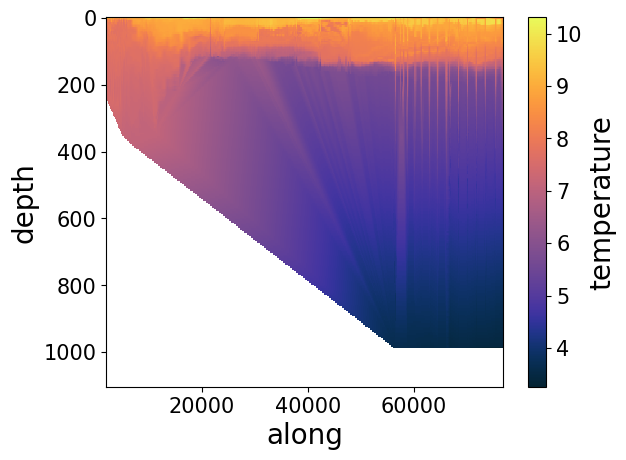

In [16]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import os
import waypoint_distance as wd  # your custom tool

def compute_along_across(ds, waypoint_lon, waypoint_lat, central_lat=51.715):
    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat
    )
    return ds.assign_coords(along=('time', alongx), across=('time', acrossx))

def interpolate_full_cube(ds, step_along=50, step_depth=5, min_depth=None, max_depth=None):
    if 'along' not in ds:
        raise ValueError("You must assign 'along' before interpolating!")

    # Create grid
    along_vals = ds['along'].values
    depth_vals = ds['depth'].values

    along_grid = np.arange(np.nanmin(along_vals), np.nanmax(along_vals) + step_along, step_along)
    if min_depth is None:
        min_depth = np.nanmin(depth_vals)
    if max_depth is None:
        max_depth = np.nanmax(depth_vals)
    depth_grid = np.arange(min_depth, max_depth + step_depth, step_depth)
    A, D = np.meshgrid(along_grid, depth_grid)

    # Build interpolation for each (depth, time) variable
    interpolated_vars = {}
    for var in ds.data_vars:
        da = ds[var]
        if da.dims != ('depth', 'time'):
            continue
        print(f"⏳ Interpolating {var}...") 

        x = ds['along'].values
        z = ds['depth'].values
        xx, zz = np.meshgrid(x, z, indexing='ij')

        points = np.column_stack((xx.ravel(), zz.ravel()))
        values = da.values.T.ravel()
        mask = ~np.isnan(values)

        if np.count_nonzero(mask) < 10:
            continue  # skip sparse variables

        interp_vals = griddata(points[mask], values[mask], (A, D), method='linear')

        interpolated_vars[var] = (['depth', 'along'], interp_vals)

    # Assemble interpolated dataset
    ds_interp = xr.Dataset(
        data_vars=interpolated_vars,
        coords={
            'depth': depth_grid,
            'along': along_grid
        }
    )
    return ds_interp

file_pathway = os.path.expanduser('~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc')
ds = xr.open_dataset(file_pathway)

# Step 1: Compute along/across
waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
ds = compute_along_across(ds, waypoint_lon, waypoint_lat)

# Step 2: Clean and interpolate full cube
ds_interp = interpolate_full_cube(ds)

# Step 3: Plot (example)
ds_interp['temperature'].plot(x='along', y='depth', cmap='cmo.thermal', yincrease=False)
print('takes foreEVER')

dict_keys(['return'])
No outbound leg found.


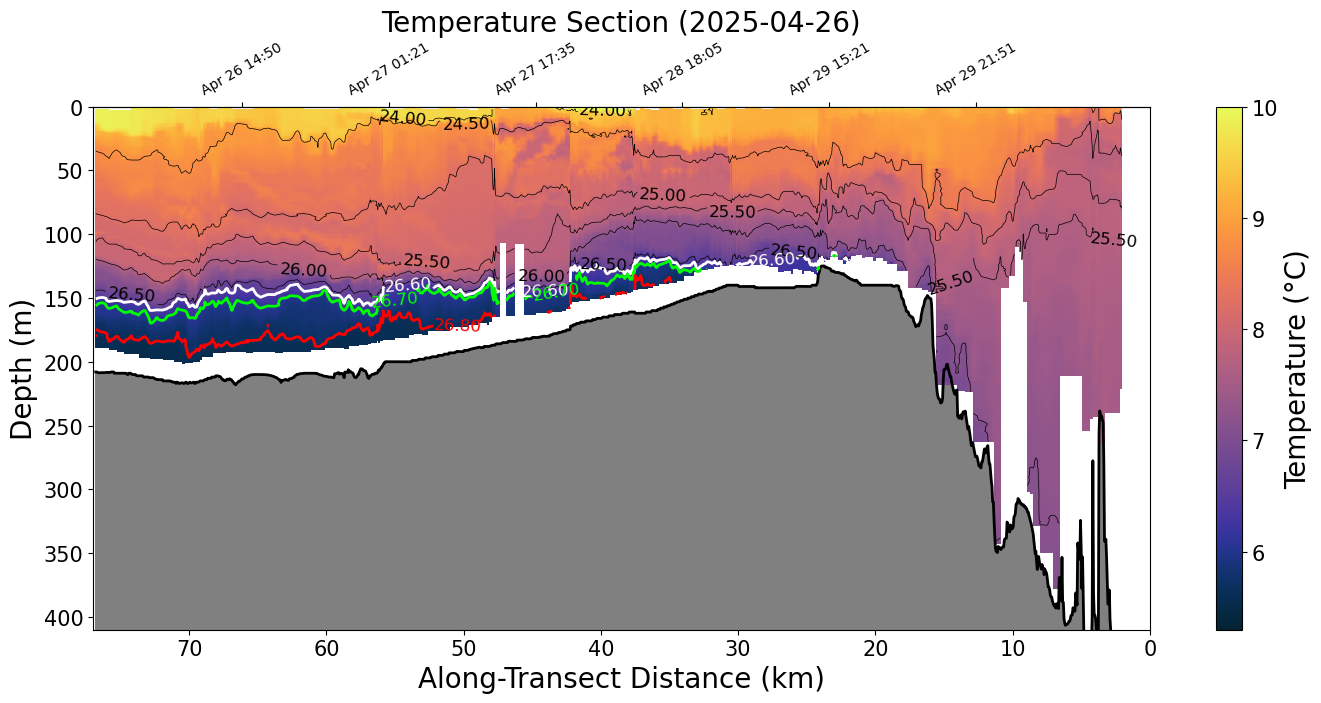

max depth is: 1099.5


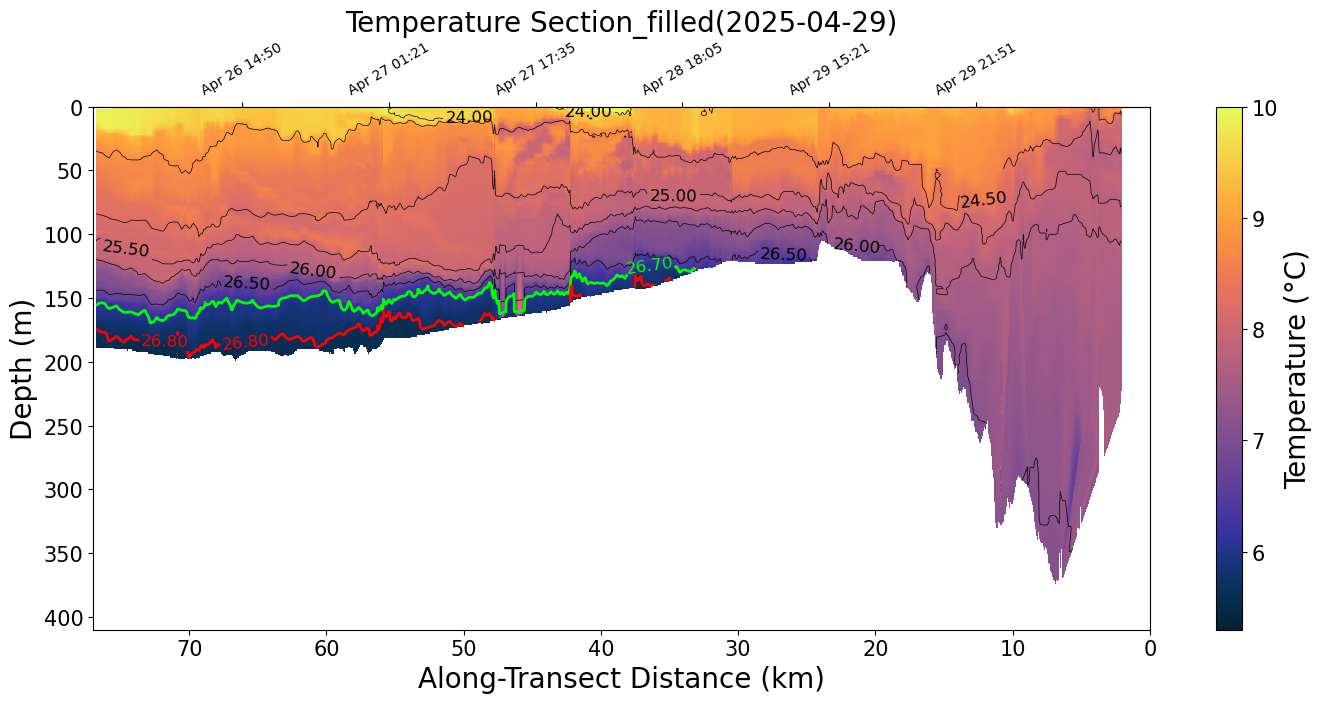

In [42]:
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import waypoint_distance as wd
import pandas as pd

def interpolate(ds, step=50):
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)

    min_along = np.floor(ds['along'].min().item() / step) * step
    max_along = np.ceil(ds['along'].max().item() / step) * step
    along_grid = np.arange(min_along, max_along + 1, step)

    ds = ds.swap_dims({'time': 'along'})
    ds_interp = ds.interp(along=along_grid)

    interp_time = np.interp(
        along_grid,
        ds['along'].values,
        ds['time'].values.astype('datetime64[ns]').astype('float64'),
        left=np.nan,
        right=np.nan
    )
    ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

    return ds_interp

file_pathway = '~/CalvertLine_reprocessed/dfo-hal1002-20250311_grid_delayed.nc'
# file_pathway = '~/Desktop/dfo-hal1002-20250506_grid.nc'
ds = xr.open_dataset(file_pathway)

waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
central_lat = 51.715

alongx, acrossx, _ = wd.get_simple_distance(
    shiplon=ds['longitude'].values,
    shiplat=ds['latitude'].values,
    wplon=waypoint_lon,
    wplat=waypoint_lat,
    central_lat=central_lat)

ds = ds.assign(along=('time', alongx), across=('time', acrossx))

peak_idx = int(np.argmax(ds['along'].values))
ds_out = ds.isel(time=slice(0, peak_idx + 1))
ds_return = ds.isel(time=slice(peak_idx + 1, None))

results = {}

for leg, name in [(ds_out, "out"), (ds_return, "return")]:
    try:
        if leg['time'].size < 2 or np.count_nonzero(~np.isnan(leg['along'])) < 10:
            continue

        prev_len = -1
        while prev_len != len(leg['time']):
            if len(leg['along']) < 3:
                raise ValueError("Too short for gradient")
            prev_len = len(leg['time'])
            grad = np.gradient(leg['along'].values)
            keep_mask = grad > 0 if name == "out" else grad < 0
            leg = leg.sel(time=keep_mask)

        if np.count_nonzero(~np.isnan(leg['along'])) < 100:
            continue

        # ✅ Interpolate before assigning to results
        leg_interp = interpolate(leg, step=50)
        results[name] = leg_interp

    except Exception as e:
        print(f"⚠️ Skipping {name} leg in {file_pathway}: {e}")
        continue

# Check what made it into results
print(results.keys())  # Should show 'out', 'return' if both passed

# Access outbound leg
ds_out_cleaned = results.get("out")

# Access return leg
ds_return_cleaned = results.get("return")

# Example: plot outbound leg
if ds_out_cleaned is not None:
    plot_section(ds_out_cleaned)
    plt.show()
else:
    print("No outbound leg found.")

# Example: plot return leg
if ds_return_cleaned is not None:
    plot_section(ds_return_cleaned)
    plt.show()
else:
    print("No return leg found.")

def plot_section_gridded(ds, xlim=77):

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    # Load bathymetry
    topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
    topo = xr.open_dataset(topo_file)
    temp_bounds = (5.3, 10)

    # Extract data
    along = ds['along'].values
    depth = ds['depth'].values
    temp = ds['temperature'].values
    pdens = ds['potential_density'].values - 1000
    lon = ds['longitude'].values
    lat = ds['latitude'].values

    # Bathymetry along track
    bottom_depths = -topo['Band1'].interp(
        lon=xr.DataArray(lon, dims='along'),
        lat=xr.DataArray(lat, dims='along'),
        method='nearest').values  # positive downward

    # Grids
    along_grid_m = np.linspace(np.nanmin(along), np.nanmax(along), 2000)
    along_grid_km = along_grid_m / 1000
    depth_grid = np.linspace(np.nanmin(depth), np.nanmax(depth), 1000)
    A, D = np.meshgrid(along_grid_m, depth_grid)
    print(f"max depth is: {np.nanmax(depth)}")
    # Interpolate bathymetry early
    bathy_interp = np.interp(along_grid_km, along / 1000, bottom_depths)
    bathy_floor = np.tile(bathy_interp, (depth_grid.size, 1))

    # Interpolation: temperature
    xx, zz = np.meshgrid(along, depth, indexing='ij')
    points = np.column_stack((xx.ravel(), zz.ravel()))
    values = temp.T.ravel()
    mask = ~np.isnan(values)

    # Get the deepest depth with valid temperature at each along point
    deepest_valid_depth = np.nan * np.ones_like(along)
    for i, a in enumerate(along):
        profile = temp[:, i]
        if np.any(~np.isnan(profile)):
            deepest_valid_depth[i] = depth[~np.isnan(profile)].max()

    # Interpolate deepest valid depth to along_grid
    deepest_valid_interp = np.interp(along_grid_m, along, deepest_valid_depth)

    # Limit valid region to shallower than both bathymetry and measurement depth
    deepest_floor = np.tile(deepest_valid_interp, (depth_grid.size, 1))
    valid_region = (D <= bathy_floor - 19) & (D <= deepest_floor)
    # valid_region = np.full_like(A, True, dtype=bool)
    # Restrict interpolation to above bathymetry
    valid_region = D <= bathy_floor - 19
    interp_points = np.column_stack((A[valid_region], D[valid_region]))

    temp_interp_values = griddata(points[mask], values[mask], interp_points, method='cubic')

    temp_masked = np.full_like(A, np.nan)
    temp_masked[valid_region] = temp_interp_values

    # Interpolation: potential density
    # Flatten potential density
    values_dens = pdens.T.ravel()
    mask_dens = ~np.isnan(values_dens)

    # Define valid interpolation region (above seafloor only)
    valid_region = D <= bathy_floor - 19
    interp_points_dens = np.column_stack((A[valid_region], D[valid_region]))

    # Interpolate ONLY above bathymetry
    pdens_interp_values = griddata(
        points[mask_dens],
        values_dens[mask_dens],
        interp_points_dens,
        method='linear')

    # Reconstruct full 2D array
    pdens_masked = np.full_like(A, np.nan)
    pdens_masked[valid_region] = pdens_interp_values

    # Plot
    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))

    # Temperature
    cf = ax.pcolormesh(along_grid_km, depth_grid, temp_masked,
                       shading='auto', cmap=cm.cm.thermal,
                       vmin=temp_bounds[0], vmax=temp_bounds[1])
    
    # Bathymetry fill
    # ax.fill_between(along_grid_km, bathy_interp, 410, facecolor='grey', zorder=5)

    # Isopycnals
    for levels, color, lw in [
        (np.linspace(24, 27, 7), 'black', 0.5),
        # ([25.6], 'black', 0.5),
        # ([25.7], 'black', 0.5),
        # ([25.8], 'black', 0.5),
        # ([25.75], 'black', 0.3),
        # ([26.6], 'white', 2),
        ([26.7], 'lime', 2),
        ([26.8], 'red', 2),
        ([26.9], 'blue', 2)]:
        iso = ax.contour(along_grid_km, depth_grid, pdens_masked, levels=levels,
                        colors=color, linewidths=lw)
        if lw != 0.3:
            ax.clabel(iso, fmt='%1.2f')

    # Time ticks on top
    time = ds['time'].values
    along_km = along / 1000
    nticks = 8
    idx = np.linspace(0, len(along_km) - 1, nticks, dtype=int)
    tick_locs = along_km[idx]
    tick_times = time[idx]
    valid = ~pd.isna(tick_times)
    tick_locs = tick_locs[valid]
    tick_times = tick_times[valid]
    tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(tick_locs)
    ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

    # Labels & layout
    ax.set_xlabel('Along-Transect Distance (km)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(xlim, 0)
    ax.set_ylim(410, 0)
    ax.set_title(f"Temperature Section_filled({pd.to_datetime(tick_times[0]).strftime('%Y-%m-%d')})")
    plt.colorbar(cf, ax=ax, label='Temperature (°C)')
    plt.tight_layout()
    plt.show()

plot_section_gridded(ds_return_cleaned)
# plot_section_gridded(ds_out_cleaned)

In [9]:
ds_return_cleaned
# Get variable to search for deepest valid point
temp = ds_return_cleaned['temperature'].values
depth = ds_return_cleaned['depth'].values
along = ds_return_cleaned['along'].values

# Find the index (i, j) of the deepest valid temperature point
i, j = np.unravel_index(np.nanargmax(~np.isnan(temp) * depth[:, None]), temp.shape)

max_depth = depth[i]
along_at_max_depth = along[j]

print(f"Max depth: {max_depth:.2f} m at along = {along_at_max_depth:.2f} m (index: {j})")

Max depth: 377.50 m at along = 6600.00 m (index: 92)


max depth is: 1099.5


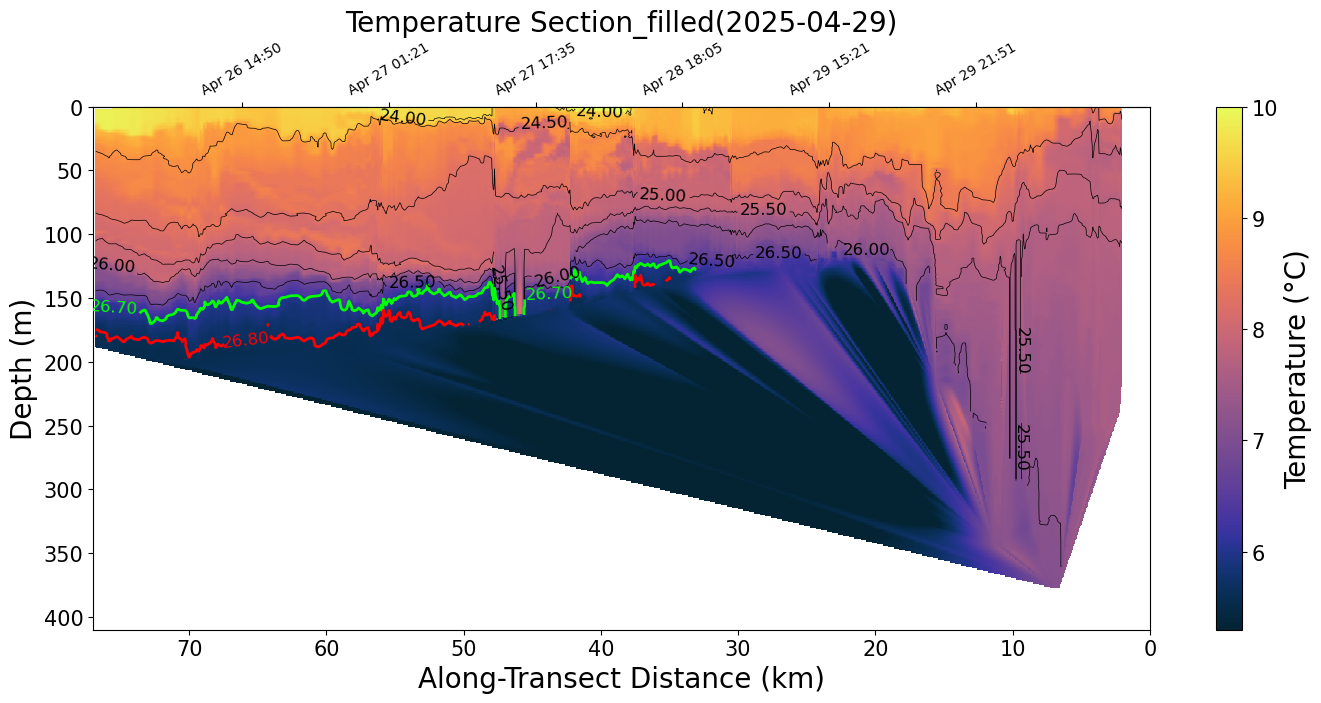

In [ ]:
ds = ds_return_cleaned
xlim = 77


plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 20,
    'figure.titlesize': 20})

# Load bathymetry
topo_file = os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
topo = xr.open_dataset(topo_file)
temp_bounds = (5.3, 10)

# Extract data
along = ds['along'].values
depth = ds['depth'].values
temp = ds['temperature'].values
pdens = ds['potential_density'].values - 1000
lon = ds['longitude'].values
lat = ds['latitude'].values

# Bathymetry along track
ocean_floor = -topo['Band1'].interp(
    lon=xr.DataArray(lon, dims='along'),
    lat=xr.DataArray(lat, dims='along'),
    method='nearest').values  # positive downward


actual_max_depth = np.nanmax(ds['depth'].values)

# Grids
along_grid_m = np.linspace(np.nanmin(along), np.nanmax(along), 1498)
along_grid_km = along_grid_m / 1000
depth_grid = np.linspace(np.nanmin(depth), actual_max_depth, 1000)

A, D = np.meshgrid(along_grid_m, depth_grid)
print(f"max depth is: {np.nanmax(depth)}")
# Interpolate bathymetry early
bathy_interp = np.interp(along_grid_km, along / 1000, ocean_floor)
bathy_floor = np.tile(bathy_interp, (depth_grid.size, 1))

# Interpolation: temperature
xx, zz = np.meshgrid(along, depth, indexing='ij')
points = np.column_stack((xx.ravel(), zz.ravel()))
values = temp.T.ravel()
mask = ~np.isnan(values)

# Get the deepest depth with valid temperature at each along point
deepest_valid_depth = np.nan * np.ones_like(along)
for i, a in enumerate(along):
    profile = temp[:, i]
    if np.any(~np.isnan(profile)):
        deepest_valid_depth[i] = depth[~np.isnan(profile)].max()

# Interpolate deepest valid depth to along_grid
deepest_valid_interp = np.interp(along_grid_m, along, deepest_valid_depth)

# Limit valid region to shallower than both bathymetry and measurement depth
deepest_floor = np.tile(deepest_valid_interp, (depth_grid.size, 1))
# valid_region = (D <= bathy_floor - 19) & (D <= deepest_floor)
valid_region_for_temp = np.full_like(A, True, dtype=bool)
# Restrict interpolation to above bathymetry
# valid_region = D <= bathy_floor - 19
interp_points = np.column_stack((A[valid_region_for_temp], D[valid_region_for_temp]))

temp_interp_values = griddata(points[mask], values[mask], interp_points, method='cubic')

temp_masked = np.full_like(A, np.nan)
temp_masked[valid_region_for_temp] = temp_interp_values

# Interpolation: potential density
# Flatten potential density
values_dens = pdens.T.ravel()
mask_dens = ~np.isnan(values_dens)

# Define valid interpolation region (above seafloor only)
valid_region_for_temp = D <= bathy_floor - 19
interp_points_dens = np.column_stack((A[valid_region_for_temp], D[valid_region_for_temp]))

# Interpolate ONLY above bathymetry
pdens_interp_values = griddata(
    points[mask_dens],
    values_dens[mask_dens],
    interp_points_dens,
    method='nearest')

# Reconstruct full 2D array
pdens_masked = np.full_like(A, np.nan)
pdens_masked[valid_region_for_temp] = pdens_interp_values

# Plot
fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))

# Temperature
cf = ax.pcolormesh(along_grid_km, depth_grid, temp_masked,
                    shading='auto', cmap=cm.cm.thermal,
                    vmin=temp_bounds[0], vmax=temp_bounds[1])

# Bathymetry fill
# ax.fill_between(along_grid_km, bathy_interp, 410, facecolor='grey', zorder=5)

# Isopycnals
for levels, color, lw in [
    (np.linspace(24, 27, 7), 'black', 0.5),
    # ([25.6], 'black', 0.5),
    # ([25.7], 'black', 0.5),
    # ([25.8], 'black', 0.5),
    # ([25.75], 'black', 0.3),
    # ([26.6], 'white', 2),
    ([26.7], 'lime', 2),
    ([26.8], 'red', 2),
    ([26.9], 'blue', 2)]:
    iso = ax.contour(along_grid_km, depth_grid, pdens_masked, levels=levels,
                    colors=color, linewidths=lw)
    if lw != 0.3:
        ax.clabel(iso, fmt='%1.2f')

# Time ticks on top
time = ds['time'].values
along_km = along / 1000
nticks = 8
idx = np.linspace(0, len(along_km) - 1, nticks, dtype=int)
tick_locs = along_km[idx]
tick_times = time[idx]
valid = ~pd.isna(tick_times)
tick_locs = tick_locs[valid]
tick_times = tick_times[valid]
tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(tick_locs)
ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=10)

# Labels & layout
ax.set_xlabel('Along-Transect Distance (km)')
ax.set_ylabel('Depth (m)')
ax.set_xlim(xlim, 0)
ax.set_ylim(410, 0)
ax.set_title(f"Temperature Section_filled({pd.to_datetime(tick_times[0]).strftime('%Y-%m-%d')})")
plt.colorbar(cf, ax=ax, label='Temperature (°C)')
plt.tight_layout()
plt.show()